Khởi tạo môi trường, import thư viện cần thiết, và cấu hình tham số cho pipeline học máy (LightGBM/XGBoost/CatBoost)
* pandas, numpy: xử lý dữ liệu dạng bảng và tính toán số.
* tqdm: tạo thanh progress bar hữu ích khi chạy vòng lặp.
* import warnings, json, os, random, gc, re, math: hỗ trợ thao tác hệ thống, cảnh báo, dọn bộ nhớ, regex, toán học.
* Ba thuật toán boosting phổ biến: LightGBM, XGBoost, CatBoost.
* Công cụ đánh giá – cross validation – pipeline: from sklearn.model_selection import, from sklearn.metrics import f1_score, from sklearn.pipeline import make_pipeline: Phục vụ xây dựng pipeline, chia Fold, đánh giá mô hình bằng F1-score.
* Polars là giải pháp thay thế Pandas với tốc độ nhanh hơn (Rust-based).
* from scipy import signal, stats: Phục vụ tiền xử lý dữ liệu phức tạp (lọc tín hiệu, thống kê…).
* Phát hiện GPU trong môi trường Kaggle để bật tăng tốc cho LightGBM/XGBoost/CatBoost.


In [ ]:
verbose = True

import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import warnings
import json
import os, random
import gc, re, math
import lightgbm
from collections import defaultdict
import polars as pl
from scipy import signal, stats
from typing import Dict, Optional, Tuple
from time import perf_counter 
from sklearn.base import ClassifierMixin, BaseEstimator, clone
from sklearn.model_selection import cross_val_predict, GroupKFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
USE_GPU = ("KAGGLE_KERNEL_RUN_TYPE" in __import__("os").environ) and (__import__("shutil").which("nvidia-smi") is not None)
print(f'Using GPU? {USE_GPU}')
 
SEED = 1234

Using GPU? True


Trong các bài toán học máy, rất nhiều thao tác bên trong mô hình là ngẫu nhiên, ví dụ:

    Chọn mẫu trong quá trình chia train/validation
    
    Khởi tạo trọng số ban đầu của mô hình
    
    Lấy mẫu ngẫu nhiên (shuffle) dữ liệu
    
    Các thuật toán boosting như LightGBM/XGBoost có nhiều bước random trong việc chọn feature, chọn split
    
    Stratified K-Fold, StratifiedShuffleSplit dùng RNG (random number generator)

Nếu không cố định Seed, mỗi lần chạy cùng một đoạn code, mô hình có thể cho kết quả khác nhau, do sự thay đổi trong các bước ngẫu nhiên. Khi đặt: SEED và truyền seed này vào tất cả module có tính ngẫu nhiên, đảm bảo rằng:

    Mọi thao tác ngẫu nhiên được định trước.
    
    Mô hình huấn luyện lại vẫn ra cùng kết quả.
    
    Có thể kiểm chứng, debug và so sánh mô hình chính xác hơn.

Ví dụ khi chạy cùng pipeline:

    Fold chia giống nhau 100%.
    
    LightGBM chọn split giống nhau.
    
    Dữ liệu được shuffle giống nhau.
    
    Trọng số mô hình khởi tạo giống nhau.

In [ ]:
# SEED 
os.environ["PYTHONHASHSEED"] = str(SEED) 

rnd = np.random.RandomState(SEED)
random.seed(SEED)
np.random.seed(SEED)

def _make_lgbm(**kw):
    kw.setdefault("random_state", SEED)
    # kw.setdefault("deterministic", True)
    # kw.setdefault("force_row_wise", True) 
    kw.setdefault("feature_fraction_seed", SEED)
    kw.setdefault("data_random_seed", SEED)
    kw.setdefault("device", 'gpu' if USE_GPU else 'cpu')
    return lightgbm.LGBMClassifier(**kw)

def _make_xgb(**kw):
    kw.setdefault("random_state", SEED)
    kw.setdefault("tree_method", "gpu_hist" if USE_GPU else "hist")
    # kw.setdefault("deterministic_histogram", True)
    return XGBClassifier(**kw)

def _make_cb(**kw):
    kw.setdefault("random_seed", SEED)
    if USE_GPU:
        kw.setdefault("task_type", "GPU")
        kw.setdefault("devices", "0")
    else:
        kw.setdefault("task_type", "CPU")

    return CatBoostClassifier(**kw)

Cố định thuật toán hash ngầm của Python bằng os.environ["PYTHONHASHSEED"] = str(SEED).
Python sử dụng hashing cho dictionary, keysset operations, sắp xếp và internal hashing
Nếu không cố định hash, mỗi lần chạy Python sẽ tạo một hàm hash khác, làm thay đổi thứ tự duyệt dictionary, ảnh hưởng đến random nội bộ của nhiều thư viện.
PYTHONHASHSEED cố định hành vi hash của Python; random.seed() và np.random.seed() khóa mọi thao tác ngẫu nhiên trong Python và NumPy; LightGBM, XGBoost và CatBoost được truyền cùng một Seed để kiểm soát các bước ngẫu nhiên nội bộ như sampling, bagging và chọn split.

In [ ]:
# ================= StratifiedSubsetClassifier =================
class StratifiedSubsetClassifierWEval(ClassifierMixin, BaseEstimator):
    def __init__(self,
                 estimator,
                 n_samples=None,
                 random_state: int = 42,
                 valid_size: float = 0.10,
                 val_cap_ratio: float = 0.25,
                 es_rounds: "int|str" = "auto",
                 es_metric: str = "auto"):
        self.estimator = estimator
        self.n_samples = (int(n_samples) if (n_samples is not None) else None)
        self.random_state = random_state
        self.valid_size = float(valid_size)
        self.val_cap_ratio = float(val_cap_ratio)
        self.es_rounds = es_rounds
        self.es_metric = es_metric
 
    # -------------------------- API --------------------------
    def fit(self, X: pd.DataFrame, y):
        y = np.asarray(y)
        n_total = len(y); assert n_total == len(X)

        tr_idx, va_idx = self._compute_train_val_indices(y, n_total)
        Xtr = X.iloc[tr_idx]; ytr = y[tr_idx]

        Xtr = Xtr.to_numpy(np.float32, copy=False)

        Xva = yva = None
        if va_idx is not None and len(va_idx) > 0:
            Xva = X.iloc[va_idx].to_numpy(np.float32, copy=False); yva = y[va_idx]

        # Compute pos_rate on VALIDATION (what ES monitors)
        pos_rate = None
        if yva is not None and len(yva) > 0:
            pos_rate = float(np.mean(yva == 1))

        # Decide metric & patience
        metric = self._choose_metric(pos_rate)
        patience = self._choose_patience(pos_rate)

        # Apply imbalance knobs per library
        if self._is_xgb(self.estimator):
            # scale_pos_weight = n_neg / n_pos on TRAIN
            n_pos = max(1, int((ytr == 1).sum()))
            n_neg = max(1, len(ytr) - n_pos)
            self.estimator.set_params(scale_pos_weight=(n_neg / n_pos))
            self.estimator.set_params(eval_metric=metric)

        elif self._is_catboost(self.estimator):
            # GPU-safe auto balancing
            try: self.estimator.set_params(auto_class_weights="Balanced")
            except Exception: pass
            try: self.estimator.set_params(eval_metric=metric)
            except Exception: pass

        # Fit with ES if we have any validation (single-class OK with Logloss)
        has_valid = (Xva is not None and len(yva) > 0)
        if has_valid and self._is_xgb(self.estimator):
            import xgboost as xgb
            self.estimator.fit(
                Xtr, ytr,
                eval_set=[(Xva, yva)],
                verbose=False,
                callbacks=[xgb.callback.EarlyStopping(
                    rounds=int(patience),
                    metric_name=metric,
                    data_name="validation_0",
                    save_best=True
                )]
            )
        elif has_valid and self._is_catboost(self.estimator):
            from catboost import Pool
            self.estimator.set_params(
                use_best_model=True,
                od_type="Iter",
                od_wait=int(patience),
                custom_metric=["PRAUC:type=Classic;hints=skip_train~true"],
            )
            self.estimator.fit(
                Xtr, ytr,
                eval_set=Pool(Xva, yva),
                verbose=False,
                metric_period=50
            )
        else:
            # Fall back: train on train split without ES
            self.estimator.fit(Xtr, ytr)

        self.classes_ = getattr(self.estimator, "classes_", np.array([0, 1]))
        self._tr_idx_ = tr_idx; self._va_idx_ = va_idx; self._pos_rate_ = pos_rate
        return self

    def predict_proba(self, X: pd.DataFrame):
        return self.estimator.predict_proba(X)

    def predict(self, X: pd.DataFrame):
        return self.estimator.predict(X)

    # -------------------------- helpers --------------------------
    def _compute_train_val_indices(self, y: np.ndarray, n_total: int):
        rng = np.random.default_rng(self.random_state)
        n_classes = np.unique(y).size

        def full_data_split():
            if self.valid_size <= 0 or n_classes < 2:
                idx = rng.permutation(n_total); return idx, None
            sss = StratifiedShuffleSplit(n_splits=1, test_size=self.valid_size, random_state=self.random_state)
            tr, va = next(sss.split(np.zeros(n_total, dtype=np.int8), y))
            return tr, va

        if self.n_samples is None or self.n_samples >= n_total:
            return full_data_split()

        # Use n_samples for train; build val from remainder (capped)
        sss_tr = StratifiedShuffleSplit(n_splits=1, train_size=self.n_samples, random_state=self.random_state)
        tr_idx, rest_idx = next(sss_tr.split(np.zeros(n_total, dtype=np.int8), y))
        remaining = len(rest_idx)

        min_val_needed = int(np.ceil(self.n_samples * max(self.valid_size, 0.0)))
        val_cap = max(min_val_needed, int(round(self.val_cap_ratio * self.n_samples)))
        want_val = min(remaining, val_cap)

        y_rest = y[rest_idx]
        if remaining < min_val_needed or np.unique(y_rest).size < 2 or self.valid_size <= 0:
            return full_data_split()

        sss_val = StratifiedShuffleSplit(n_splits=1, train_size=want_val, random_state=self.random_state)
        try:
            va_sel, _ = next(sss_val.split(np.zeros(remaining, dtype=np.int8), y_rest))
        except ValueError:
            return full_data_split()

        va_idx = rest_idx[va_sel]
        return tr_idx, va_idx

    def _choose_metric(self, pos_rate=0.01) -> str:
        if self.es_metric != "auto":
            return self.es_metric
        if pos_rate is None or pos_rate == 0.0 or pos_rate == 1.0:
            return "logloss" if self._is_xgb(self.estimator) else "Logloss"
        return "aucpr" if self._is_xgb(self.estimator) else "PRAUC:type=Classic"

    def _choose_patience(self, pos_rate: Optional[float]) -> int:
        if isinstance(self.es_rounds, int):
            return self.es_rounds
        try:
            n_estimators = (int(self.estimator.get_params().get("n_estimators", 200))
                            if self._is_xgb(self.estimator)
                            else int(self.estimator.get_params().get("iterations", 500)))
        except Exception:
            n_estimators = 200
        base = max(30, int(round(0.20 * (n_estimators or 200))))
        if pos_rate is None:
            return base
        if pos_rate < 0.005:   # <0.5%
            return int(round(base * 1.75))
        if pos_rate < 0.02:    # <2%
            return int(round(base * 1.40))
        return base

    @staticmethod
    def _is_xgb(est):
        name = est.__class__.__name__.lower(); mod = getattr(est, "__module__", "")
        return "xgb" in name or "xgboost" in mod or hasattr(est, "get_xgb_params")

    @staticmethod
    def _is_catboost(est):
        name = est.__class__.__name__.lower(); mod = getattr(est, "__module__", "")
        return "catboost" in name or "catboost" in mod or hasattr(est, "get_all_params")


class StratifiedSubsetClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, estimator, n_samples, random_state=SEED):
        self.estimator = estimator
        self.n_samples = n_samples and int(n_samples)
        self.random_state = random_state

    def fit(self, X, y):
        y = np.asarray(y)
        n_total = len(y)

        if self.n_samples is None or self.n_samples >= n_total:
            rng = np.random.default_rng(self.random_state)
            idx = rng.permutation(n_total)
        else:
            sss = StratifiedShuffleSplit(
                n_splits=1, train_size=self.n_samples, random_state=self.random_state
            )
            idx, _ = next(sss.split(np.zeros(n_total, dtype=np.int8), y))

        Xn = X.iloc[idx]
        Xn = Xn.to_numpy(np.float32, copy=False)
        yn = y[idx]

        self.estimator.fit(Xn, yn)
        self.classes_ = getattr(self.estimator, "classes_", np.array([0, 1]))
        return self

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def predict(self, X):
        return self.estimator.predict(X)

Hai lớp StratifiedSubsetClassifierWEval và StratifiedSubsetClassifier được thiết kế như một wrapper thông minh cho các mô hình Boosting (XGBoost, CatBoost, LightGBM), với mục tiêu chính là huấn luyện nhanh hơn trên tập con dữ liệu nhưng vẫn duy trì độ tin cậy về phân phối lớp, khả năng đánh giá, và tính ổn định của mô hình. Ý tưởng cốt lõi nằm ở việc áp dụng Stratified Sampling, tức là lựa chọn mẫu theo cách giữ nguyên tỷ lệ giữa các lớp trong toàn bộ tập dữ liệu, giúp mô hình học được phân bố thật ngay cả khi chỉ dùng một phần nhỏ dataset.

Phiên bản nâng cao StratifiedSubsetClassifierWEval bổ sung một cơ chế tách tập validation hợp lý, cũng theo phân tầng, đồng thời có các tham số linh hoạt như valid_size, val_cap_ratio và n_samples, cho phép điều khiển kích thước train/validation sao cho không quá lớn nhưng vẫn đủ đại diện. Lớp này còn tự động chọn metric Early Stopping dựa trên tỷ lệ lớp của validation, ví dụ: nếu dữ liệu bị mất cân bằng mạnh thì ưu tiên sử dụng AUPRC/PRAUC, nếu validation bị “single-class” thì fallback về logloss — đảm bảo thuật toán vẫn hoạt động ổn định trong mọi trường hợp.

Trong quá trình huấn luyện, wrapper cũng tự động áp dụng các kỹ thuật xử lý mất cân bằng cho từng loại mô hình:

Với XGBoost, tự động tính scale_pos_weight = n_neg / n_pos từ tập train.

Với CatBoost, kích hoạt auto_class_weights="Balanced" khi phù hợp.

Đồng thời cấu hình Early Stopping đúng chuẩn của từng thư viện, truyền eval_set và giữ mô hình tốt nhất.

Toàn bộ pipeline được kiểm soát bởi tham số random_state, đảm bảo các bước chọn mẫu, shuffle, chia validation, và huấn luyện đều tái lập được 100%.

Trong khi đó, StratifiedSubsetClassifier là phiên bản rút gọn, chỉ thực hiện việc chọn tập con có phân tầng và huấn luyện trực tiếp mà không liên quan đến validation hay Early Stopping. Lớp này phù hợp khi muốn chạy thử mô hình nhanh hoặc kiểm tra baseline.

Tổng thể, hai lớp này giúp tăng tốc quá trình thử nghiệm trên tập dữ liệu lớn, cải thiện sự ổn định trong điều kiện mất cân bằng lớp, tự động hóa tách validation và Early Stopping, đồng thời duy trì tính reproducible trong toàn bộ pipeline.

In [4]:
# ==================== SCORING FUNCTIONS ====================

class HostVisibleError(Exception):
    pass

def single_lab_f1(lab_solution: pl.DataFrame, lab_submission: pl.DataFrame, beta: float = 1) -> float:
    label_frames: defaultdict[str, set[int]] = defaultdict(set)
    prediction_frames: defaultdict[str, set[int]] = defaultdict(set)

    for row in lab_solution.to_dicts():
        label_frames[row['label_key']].update(range(row['start_frame'], row['stop_frame']))

    for video in lab_solution['video_id'].unique():
        active_labels: str = lab_solution.filter(pl.col('video_id') == video)['behaviors_labeled'].first()
        active_labels: set[str] = set(json.loads(active_labels))
        predicted_mouse_pairs: defaultdict[str, set[int]] = defaultdict(set)

        for row in lab_submission.filter(pl.col('video_id') == video).to_dicts():
            if ','.join([str(row['agent_id']), str(row['target_id']), row['action']]) not in active_labels:
                continue
           
            new_frames = set(range(row['start_frame'], row['stop_frame']))
            new_frames = new_frames.difference(prediction_frames[row['prediction_key']])
            prediction_pair = ','.join([str(row['agent_id']), str(row['target_id'])])
            if predicted_mouse_pairs[prediction_pair].intersection(new_frames):
                raise HostVisibleError('Multiple predictions for the same frame from one agent/target pair')
            prediction_frames[row['prediction_key']].update(new_frames)
            predicted_mouse_pairs[prediction_pair].update(new_frames)

    tps = defaultdict(int)
    fns = defaultdict(int)
    fps = defaultdict(int)
    for key, pred_frames in prediction_frames.items():
        action = key.split('_')[-1]
        matched_label_frames = label_frames[key]
        tps[action] += len(pred_frames.intersection(matched_label_frames))
        fns[action] += len(matched_label_frames.difference(pred_frames))
        fps[action] += len(pred_frames.difference(matched_label_frames))

    distinct_actions = set()
    for key, frames in label_frames.items():
        action = key.split('_')[-1]
        distinct_actions.add(action)
        if key not in prediction_frames:
            fns[action] += len(frames)

    action_f1s = []
    for action in distinct_actions:
        if tps[action] + fns[action] + fps[action] == 0:
            action_f1s.append(0)
        else:
            action_f1s.append((1 + beta**2) * tps[action] / ((1 + beta**2) * tps[action] + beta**2 * fns[action] + fps[action]))
    return sum(action_f1s) / len(action_f1s)

def mouse_fbeta(solution: pd.DataFrame, submission: pd.DataFrame, beta: float = 1) -> float:
    if len(solution) == 0 or len(submission) == 0:
        raise ValueError('Missing solution or submission data')

    expected_cols = ['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']

    for col in expected_cols:
        if col not in solution.columns:
            raise ValueError(f'Solution is missing column {col}')
        if col not in submission.columns:
            raise ValueError(f'Submission is missing column {col}')

    solution: pl.DataFrame = pl.DataFrame(solution)
    submission: pl.DataFrame = pl.DataFrame(submission)
    assert (solution['start_frame'] <= solution['stop_frame']).all()
    assert (submission['start_frame'] <= submission['stop_frame']).all()
    solution_videos = set(solution['video_id'].unique())
    submission = submission.filter(pl.col('video_id').is_in(solution_videos))

    solution = solution.with_columns(
        pl.concat_str(
            [
                pl.col('video_id').cast(pl.Utf8),
                pl.col('agent_id').cast(pl.Utf8),
                pl.col('target_id').cast(pl.Utf8),
                pl.col('action'),
            ],
            separator='_',
        ).alias('label_key'),
    )
    submission = submission.with_columns(
        pl.concat_str(
            [
                pl.col('video_id').cast(pl.Utf8),
                pl.col('agent_id').cast(pl.Utf8),
                pl.col('target_id').cast(pl.Utf8),
                pl.col('action'),
            ],
            separator='_',
        ).alias('prediction_key'),
    )

    lab_scores = []
    for lab in solution['lab_id'].unique():
        lab_solution = solution.filter(pl.col('lab_id') == lab).clone()
        lab_videos = set(lab_solution['video_id'].unique())
        lab_submission = submission.filter(pl.col('video_id').is_in(lab_videos)).clone()
        lab_scores.append(single_lab_f1(lab_solution, lab_submission, beta=beta))

    return sum(lab_scores) / len(lab_scores)

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, beta: float = 1) -> float:
    solution = solution.drop(row_id_column_name, axis='columns', errors='ignore')
    submission = submission.drop(row_id_column_name, axis='columns', errors='ignore')
    return mouse_fbeta(solution, submission, beta=beta)

(Scoring Functions)

Phần tính điểm được xây dựng để tái hiện chính xác cách chấm của bài toán "Mouse Action Detection". Mỗi dự đoán không chỉ là một nhãn, mà còn gắn với khoảng thời gian liên tục (start_frame → stop_frame) và mỗi mẫu gồm nhiều hành vi đồng thời giữa các cặp chuột (agent–target). Vì vậy metric phải đánh giá theo frame-level thay vì sample-level.

Cốt lõi của hệ thống chấm điểm nằm ở hàm single_lab_f1, nơi dữ liệu ground truth và prediction được quy đổi thành tập các frame ứng với từng hành động. Mỗi cặp (video, agent, target, action) được ánh xạ thành một khóa duy nhất gọi là label_key hoặc prediction_key, và sau đó các frame trong khoảng [start_frame, stop_frame) được đưa vào một set. Việc dùng set đảm bảo tính toán chính xác số frame trùng khớp mà không bị double-count.

Trong quá trình xử lý từng video, hệ thống còn áp dụng một lớp lọc prediction: chỉ những hành vi nằm trong danh sách các hành vi ground truth của video đó (behaviors_labeled) mới được chấp nhận. Điều này tránh trường hợp mô hình bịa thê hành vi không xuất hiện trong video, vốn sẽ bị phạt nặng. Thêm vào đó, mỗi cặp chuột chỉ được phép đưa ra một dự đoán cho một frame, nếu không sẽ bị ném lỗi HostVisibleError — bảo đảm tính hợp lệ của submission.

Sau khi thu được tập frame dự đoán và gán nhãn, thuật toán tính TP / FP / FN theo từng action và gom thành F1 theo công thức Fβ mở rộng.

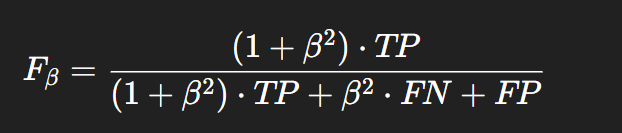

Điểm cho một lab là trung bình F1 của tất cả các action trong lab đó.
Hàm mouse_fbeta lặp qua từng lab_id, tách submission tương ứng, tính điểm bằng single_lab_f1, rồi cuối cùng lấy trung bình các lab – đây là lý do metric rất nhạy với những lab có ít hành động.

Hàm score chỉ đóng vai trò bao bọc lại việc drop cột row_id_column_name và trả về giá trị cuối cùng.

Toàn bộ thiết kế giúp mô phỏng đúng yêu cầu của contest:

đánh giá theo frame-level thay vì event-level,

xử lý theo từng lab để tránh bias do số lượng video khác nhau,

kiểm soát chặt chẽ tính hợp lệ của submission,

và sử dụng F1 cho dữ liệu hành vi hiếm (imbalanced behaviors).

In [5]:
# ==================== DATA LOADING ====================

train = pd.read_csv('/kaggle/input/MABe-mouse-behavior-detection/train.csv')

# drop likely-sleeping MABe22 clips: condition == "lights on"
train = train.loc[~(train['lab_id'].astype(str).str.contains('MABe22', na=False) &
                    train['mouse1_condition'].astype(str).str.lower().eq('lights on'))].copy()

train['n_mice'] = 4 - train[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1)

test = pd.read_csv('/kaggle/input/MABe-mouse-behavior-detection/test.csv')
test['sleeping'] = (
    test['lab_id'].astype(str).str.contains('MABe22', na=False) &
    test['mouse1_condition'].astype(str).str.lower().eq('lights on')
)
test['n_mice'] = 4 - test[['mouse1_strain','mouse2_strain','mouse3_strain','mouse4_strain']].isna().sum(axis=1)

body_parts_tracked_list = list(np.unique(train.body_parts_tracked))

drop_body_parts = ['headpiece_bottombackleft', 'headpiece_bottombackright', 'headpiece_bottomfrontleft', 'headpiece_bottomfrontright', 
                   'headpiece_topbackleft', 'headpiece_topbackright', 'headpiece_topfrontleft', 'headpiece_topfrontright',                  
                   'spine_1', 'spine_2', 'tail_middle_1', 'tail_middle_2', 'tail_midpoint']

_sex_cols = [f'mouse{i}_sex' for i in range(1,5)]
_train_sex_lut = (train[['video_id'] + _sex_cols].drop_duplicates('video_id')
                  .set_index('video_id').to_dict('index'))
_test_sex_lut  = (test[['video_id']  + _sex_cols].drop_duplicates('video_id')
                  .set_index('video_id').to_dict('index'))
_FEATURE_TEMPLATES = {}

def generate_mouse_data(dataset, traintest, traintest_directory=None,
                        generate_single=True, generate_pair=True):
    assert traintest in ['train', 'test']
    if traintest_directory is None:
        traintest_directory = f"/kaggle/input/MABe-mouse-behavior-detection/{traintest}_tracking"

    def _to_num(x):
        if isinstance(x, (int, np.integer)): return int(x)
        m = re.search(r'(\d+)$', str(x))
        return int(m.group(1)) if m else None

    for _, row in dataset.iterrows():
        lab_id   = row.lab_id
        video_id = row.video_id
        fps      = float(row.frames_per_second)
        n_mice   = int(row.n_mice)
        arena_w  = float(row.get('arena_width_cm', np.nan))
        arena_h  = float(row.get('arena_height_cm', np.nan))
        sleeping = bool(getattr(row, 'sleeping', False))
        arena_shape = row.get('arena_shape', 'rectangular')

        if not isinstance(row.behaviors_labeled, str):
            continue

        # ---- tracking ----
        path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        vid = pd.read_parquet(path)
        if len(np.unique(vid.bodypart)) > 5:
            vid = vid.query("~ bodypart.isin(@drop_body_parts)")
        pvid = vid.pivot(columns=['mouse_id','bodypart'], index='video_frame', values=['x','y'])
        del vid
        pvid = pvid.reorder_levels([1,2,0], axis=1).T.sort_index().T
        pvid = (pvid / float(row.pix_per_cm_approx)).astype('float32', copy=False)

        # available mouse_id labels in tracking (could be ints or strings)
        avail = list(pvid.columns.get_level_values('mouse_id').unique())
        avail_set = set(avail) | set(map(str, avail)) | {f"mouse{_to_num(a)}" for a in avail if _to_num(a) is not None}

        def _resolve(agent_str):
            """Return the matching mouse_id label present in pvid (int or str), or None."""
            m = re.search(r'(\d+)$', str(agent_str))
            cand = [agent_str]
            if m:
                n = int(m.group(1))
                cand = [n, n-1, str(n), f"mouse{n}", agent_str]  # try 1-based, 0-based, str, canonical
            for c in cand:
                if c in avail_set:  # compare within unified set
                    # return the exact label used in columns
                    if c in set(avail): return c
                    # map back to the exact label that exists (int preferred)
                    for a in avail:
                        if str(a) == str(c) or f"mouse{_to_num(a)}" == str(c):
                            return a
            return None

        # ---- behaviors ----
        vb = json.loads(row.behaviors_labeled)
        vb = sorted(list({b.replace("'", "") for b in vb}))
        vb = pd.DataFrame([b.split(',') for b in vb], columns=['agent','target','action'])
        vb['agent']  = vb['agent'].astype(str)
        vb['target'] = vb['target'].astype(str)
        vb['action'] = vb['action'].astype(str).str.lower()

        if traintest == 'train':
            try:
                annot = pd.read_parquet(path.replace('train_tracking', 'train_annotation'))
            except FileNotFoundError:
                continue

        def _mk_meta(index, agent_id, target_id):
            m = pd.DataFrame({
                'lab_id':        lab_id,
                'video_id':      video_id,
                'agent_id':      agent_id,
                'target_id':     target_id,
                'video_frame':   index.astype('int32', copy=False),
                'frames_per_second': np.float32(fps),
                'sleeping':      sleeping,
                'arena_shape':   arena_shape,
                'arena_width_cm': np.float32(arena_w),
                'arena_height_cm': np.float32(arena_h),
                'n_mice':        np.int8(n_mice),
            })
            for c in ('lab_id','video_id','agent_id','target_id','arena_shape'):
                m[c] = m[c].astype('category')
            return m

        # ---------- SINGLE ----------
        if generate_single:
            vb_single = vb.query("target == 'self'")
            for agent_str in pd.unique(vb_single['agent']):
                col_lab = _resolve(agent_str)
                if col_lab is None:
                    # if verbose: print(f"[skip single] {video_id} missing {agent_str} in tracking (avail={sorted(avail)})")
                    continue
                actions = sorted(vb_single.loc[vb_single['agent'].eq(agent_str), 'action'].unique().tolist())
                if not actions:
                    continue

                single = pvid.loc[:, col_lab]
                meta_df = _mk_meta(single.index, agent_str, 'self')

                if traintest == 'train':
                    a_num = _to_num(col_lab)
                    y = pd.DataFrame(False, index=single.index.astype('int32', copy=False), columns=actions)
                    a_sub = annot.query("(agent_id == @a_num) & (target_id == @a_num)")
                    for i in range(len(a_sub)):
                        ar = a_sub.iloc[i]
                        a = str(ar.action).lower()
                        if a in y.columns:
                            y.loc[int(ar['start_frame']):int(ar['stop_frame']), a] = True
                    yield 'single', single, meta_df, y
                else:
                    yield 'single', single, meta_df, actions

        # ---------- PAIR (ONLY LABELED PAIRS) ----------
        if generate_pair:
            vb_pair = vb.query("target != 'self'")
            if len(vb_pair) > 0:
                allowed_pairs = set(map(tuple, vb_pair[['agent','target']].itertuples(index=False, name=None)))

                for agent_num, target_num in itertools.permutations(
                        np.unique(pvid.columns.get_level_values('mouse_id')), 2):
                    agent_str = f"mouse{_to_num(agent_num)}"
                    target_str = f"mouse{_to_num(target_num)}"
                    if (agent_str, target_str) not in allowed_pairs:
                        continue

                    a_col = _resolve(agent_str)
                    b_col = _resolve(target_str)
                    if a_col is None or b_col is None:
                        # if verbose: print(f"[skip pair] {video_id} missing {agent_str}->{target_str}")
                        continue

                    actions = sorted(
                        vb_pair.query("(agent == @agent_str) & (target == @target_str)")['action'].unique().tolist()
                    )
                    if not actions:
                        continue

                    pair_xy = pd.concat([pvid[a_col], pvid[b_col]], axis=1, keys=['A','B'])
                    meta_df = _mk_meta(pair_xy.index, agent_str, target_str)

                    if traintest == 'train':
                        a_num = _to_num(a_col); b_num = _to_num(b_col)
                        y = pd.DataFrame(False, index=pair_xy.index.astype('int32', copy=False), columns=actions)
                        a_sub = annot.query("(agent_id == @a_num) & (target_id == @b_num)")
                        for i in range(len(a_sub)):
                            ar = a_sub.iloc[i]
                            a = str(ar.action).lower()
                            if a in y.columns:
                                y.loc[int(ar['start_frame']):int(ar['stop_frame']), a] = True
                        yield 'pair', pair_xy, meta_df, y
                    else:
                        yield 'pair', pair_xy, meta_df, actions

1. Khởi Tạo và Lọc Dữ liệu (Data Initialization and Filtering)
Tải Dữ liệu Gốc: Code bắt đầu bằng việc tải hai tập dữ liệu chính: train.csv (huấn luyện) và test.csv (kiểm thử).
Lọc Dữ liệu Ngủ: Một bước tiền xử lý quan trọng được thực hiện trên tập train là loại bỏ các clip từ bộ MABe22 được quay trong điều kiện "lights on" (thường là thời gian chuột nghỉ/ngủ), vì những clip này không chứa hành vi đa dạng. Tập test chỉ được đánh dấu cột sleeping chứ không bị loại bỏ.
Tính Số Lượng Chuột (n_mice): Xác định số lượng chuột thực tế trong mỗi video bằng cách đếm các cột strain không bị thiếu (NaN).
Loại bỏ Điểm Theo Dõi: Danh sách drop_body_parts định nghĩa các bộ phận cơ thể (tracking points) sẽ bị loại bỏ sau này, thường là các điểm ít thông tin hoặc gây nhiễu.

2. Hàm Xử Lý Dữ Liệu Cốt Lõi: generate_mouse_data
Đây là một hàm generator (hàm sinh) có nhiệm vụ lặp qua từng video và tạo ra các mẫu dữ liệu (data samples) ở cấp độ frame-by-frame, được chuẩn hóa theo hai loại: Hành vi Đơn và Hành vi Cặp.

A. Tải và Chuẩn hóa Dữ liệu Tọa độ (Tracking Data)
Tải Tọa độ Thô: Đối với mỗi video, code tải tệp .parquet chứa dữ liệu theo dõi tọa độ $x, y$ của các body parts theo thời gian.
Chuyển đổi Định dạng: Dữ liệu được chuyển đổi thành định dạng "rộng" (wide format) trong DataFrame pvid, nơi các cột được tổ chức theo cấp độ: (mouse_id, bodypart, x/y). 
Index là video_frame.
Chuẩn hóa Đơn vị: Tọa độ pixel thô được chia cho hệ số pix_per_cm_approx để chuyển đổi tọa độ từ pixel sang centimet (cm), giúp dữ liệu có ý nghĩa vật lý và dễ so sánh hơn.

B. Ánh xạ ID Chuột (_resolve)
Một bước thiết yếu là ánh xạ (mapping) 
ID chuột được sử dụng trong nhãn hành vi (mouse1, mouse2, v.v.) với ID chuột thực sự có trong dữ liệu tọa độ (1, 2, '1', '2', v.v.). 
Hàm _resolve đảm bảo tính nhất quán giữa dữ liệu hành vi và dữ liệu tọa độ.

C. Trích xuất Mẫu Dữ liệu và Nhãn
Hàm này tạo và trả về (yield) các mẫu dữ liệu đã được xử lý:
Mẫu Hành vi Đơn (target == 'self'):
* Features (X): Chọn dữ liệu tọa độ của một con chuột (Agent A).
* Nhãn (Y) (Chỉ áp dụng cho train): Dữ liệu annotation chi tiết được tải và chuyển thành DataFrame boolean, đánh dấu True cho các frame mà hành vi đơn lẻ (ví dụ: grooming, sniffing) đang diễn ra.
* Đầu ra: Trả về features (tọa độ A), metadata, và nhãn Y (nếu là train).

Mẫu Hành vi Cặp (target != 'self'):
* Lọc Cặp: Chỉ xử lý các cặp chuột (Agent A, Target B) đã được gán nhãn tương tác.
* Features (X): Ghép (concatenate) dữ liệu tọa độ của hai con chuột (Agent A và Target B) thành một DataFrame duy nhất.
* Nhãn (Y) (Chỉ áp dụng cho train): Nhãn hành vi tương tác (ví dụ: chase, attack) được ánh xạ thành DataFrame boolean tương ứng.
* Đầu ra: Trả về features (tọa độ A+B), metadata, và nhãn Y (nếu là train).

In [6]:
# ==================== ADAPTIVE THRESHOLDING ====================

def predict_multiclass_adaptive(pred, meta, action_thresholds=defaultdict(lambda: 0.27)):
    """Adaptive thresholding per action + temporal smoothing"""
    # Apply temporal smoothing
    pred_smoothed = pred.rolling(window=5, min_periods=1, center=True).mean()
    
    ama = np.argmax(pred_smoothed, axis=1)
    
    max_probs = pred_smoothed.max(axis=1)
    threshold_mask = np.zeros(len(pred_smoothed), dtype=bool)
    for i, action in enumerate(pred_smoothed.columns):
        action_mask = (ama == i)
        threshold = action_thresholds.get(action, 0.27)
        threshold_mask |= (action_mask & (max_probs >= threshold))
    
    ama = np.where(threshold_mask, ama, -1)
    ama = pd.Series(ama, index=meta.video_frame)
    
    changes_mask = (ama != ama.shift(1)).values
    ama_changes = ama[changes_mask]
    meta_changes = meta[changes_mask]
    mask = ama_changes.values >= 0
    mask[-1] = False
    
    submission_part = pd.DataFrame({
        'video_id': meta_changes['video_id'][mask].values,
        'agent_id': meta_changes['agent_id'][mask].values,
        'target_id': meta_changes['target_id'][mask].values,
        'action': pred.columns[ama_changes[mask].values],
        'start_frame': ama_changes.index[mask],
        'stop_frame': ama_changes.index[1:][mask[:-1]]
    })
    
    stop_video_id = meta_changes['video_id'][1:][mask[:-1]].values
    stop_agent_id = meta_changes['agent_id'][1:][mask[:-1]].values
    stop_target_id = meta_changes['target_id'][1:][mask[:-1]].values
    
    for i in range(len(submission_part)):
        video_id = submission_part.video_id.iloc[i]
        agent_id = submission_part.agent_id.iloc[i]
        target_id = submission_part.target_id.iloc[i]
        if i < len(stop_video_id):
            if stop_video_id[i] != video_id or stop_agent_id[i] != agent_id or stop_target_id[i] != target_id:
                new_stop_frame = meta.query("(video_id == @video_id)").video_frame.max() + 1
                submission_part.iat[i, submission_part.columns.get_loc('stop_frame')] = new_stop_frame
        else:
            new_stop_frame = meta.query("(video_id == @video_id)").video_frame.max() + 1
            submission_part.iat[i, submission_part.columns.get_loc('stop_frame')] = new_stop_frame
    
    # Filter out very short events (likely noise)
    duration = submission_part.stop_frame - submission_part.start_frame
    submission_part = submission_part[duration >= 3].reset_index(drop=True)
    
    if len(submission_part) > 0:
        assert (submission_part.stop_frame > submission_part.start_frame).all(), 'stop <= start'
    
    if verbose: print(f'  actions found: {len(submission_part)}')
    return submission_part

Hàm predict_multiclass_adaptive() thực hiện toàn bộ bước hậu xử lý dự đoán đa lớp bằng cách kết hợp ba kỹ thuật chính: làm mượt theo thời gian, ngưỡng thích ứng theo từng hành động và tái cấu trúc thành các phân đoạn hợp lệ. Trước hết, dự đoán frame-level được làm mượt bằng trung bình trượt 5 frame để giảm nhiễu và hạn chế tình trạng mô hình nhảy liên tục giữa các hành động. Sau đó, hàm áp dụng “adaptive thresholding”, tức là mỗi action được kiểm tra với một ngưỡng xác suất riêng nhằm tránh các kích hoạt giả khi xác suất cao tương đối nhưng vẫn thấp tuyệt đối, đặc biệt hiệu quả với các hành động hiếm. Khi xác định được action hợp lệ tại từng frame, hàm chuyển chuỗi dự đoán thành các phân đoạn liên tục bằng cách phát hiện các điểm thay đổi nhãn (state transition) để tạo start_frame và stop_frame. Tiếp theo, hàm xử lý các trường hợp phân đoạn bị lệch video/agent/target – thường phát sinh do smoothing – bằng cách điều chỉnh lại điểm kết thúc sao cho mỗi đoạn hoàn toàn nằm trong đúng video và đúng đối tượng. Cuối cùng, các đoạn có độ dài quá ngắn (dưới 3 frame) bị loại bỏ vì gần như luôn là nhiễu, giúp tăng độ tin cậy của kết quả. Kết quả trả về là một bảng sự kiện chuẩn hóa với video_id, agent_id, action, và start–stop frame, sẵn sàng dùng cho submission.

Adaptive thresholding là kỹ thuật dùng để quyết định xem một hành động có thật sự xảy ra hay không dựa trên xác suất dự đoán theo từng khung hình. Thay vì chọn hành động có xác suất cao nhất một cách trực tiếp, kỹ thuật này áp dụng các ngưỡng riêng cho từng hành động. Mỗi hành động sẽ có một ngưỡng tối thiểu để được xem là hợp lệ. Điều này giúp giảm nhiễu và hạn chế các dự đoán sai lệch ở những hành động có xác suất thấp.

Bên cạnh đó, dự đoán theo thời gian thường dao động và dễ bị nhiễu. Vì vậy phương pháp này sử dụng bước làm mượt theo thời gian bằng cửa sổ trượt. Việc làm mượt giúp xác suất ổn định hơn và phản ánh xu hướng thực sự của hành động thay vì phản ứng với các điểm bất thường tức thời.

Sau khi chọn được hành động hợp lệ theo ngưỡng, mô hình tiến hành phát hiện điểm thay đổi hành động bằng cách so sánh dự đoán giữa các khung hình liên tiếp. Mỗi lần hành động thay đổi sẽ đánh dấu bắt đầu một sự kiện mới. Khi hành động mới xuất hiện, hệ thống xác định khung hình bắt đầu và khung hình kết thúc nhằm tạo thành một sự kiện hoàn chỉnh.

Kỹ thuật này cũng đảm bảo rằng các sự kiện ngắn bất thường không được đưa vào kết quả cuối cùng. Những sự kiện có độ dài quá ngắn thường là nhiễu nên sẽ bị loại bỏ. Cuối cùng thuật toán bảo đảm tính nhất quán giữa video agent và target để tránh các đoạn sự kiện bị đóng sai video.

Nhờ áp dụng ngưỡng theo từng hành động, làm mượt thời gian và kiểm soát chất lượng sự kiện, adaptive thresholding giúp tăng độ chính xác và độ ổn định của kết quả dự đoán trong các bài toán nhận dạng hành động theo chuỗi thời gian.

In [ ]:
# ==================== ADVANCED FEATURE ENGINEERING (FPS-AWARE) ====================

def safe_rolling(series, window, func, min_periods=None):
    """
    Thực hiện rolling (cửa sổ trượt) một cách an toàn khi dữ liệu có NaN.

    - Không làm thay đổi series gốc
    - Chỉ tạo ra FEATURE mới đã được làm mượt / thống kê
    - Cho phép thiếu dữ liệu trong window (tránh ra toàn NaN)
    """
    # Nếu không chỉ định min_periods:
    # → cho phép thiếu dữ liệu trong cửa sổ
    # → mặc định cần tối thiểu 1/4 số điểm của window
    if min_periods is None:
        min_periods = max(1, window // 4)

    # rolling với:
    # - window: số frame trong cửa sổ
    # - min_periods: số điểm tối thiểu để vẫn tính được
    # - center=True: cửa sổ đặt giữa frame hiện tại (có dùng cả quá khứ + tương lai)
    # - apply(func, raw=True): func nhận numpy array (nhanh hơn)
    return series.rolling(
        window,
        min_periods=min_periods,
        center=True
    ).apply(func, raw=True)


def _scale(n_frames_at_30fps, fps, ref=30.0):
    """
    Scale số frame được định nghĩa theo chuẩn 30fps
    sang số frame tương ứng với fps thực của video.

    Dùng cho:
    - window size của rolling
    - smoothing
    (KHÔNG dùng cho shift có hướng)
    """
    # Công thức:
    # n_frames_new = n_frames_30fps * fps / 30
    # round để giữ đúng độ dài theo thời gian
    # max(1, ...) để window không bao giờ = 0 frame
    return max(
        1,
        int(round(n_frames_at_30fps * float(fps) / ref))
    )


def _scale_signed(n_frames_at_30fps, fps, ref=30.0):
    """
    Scale số frame CÓ DẤU (+/-) theo fps,
    dùng cho shift (dịch dữ liệu theo thời gian).

    Đảm bảo:
    - Giữ đúng hướng (quá khứ / tương lai)
    - Giữ đúng độ dài theo thời gian
    - Shift = 0 thì vẫn là 0 (không bị ép thành 1)
    """

    # Trường hợp đặc biệt:
    # Nếu không shift thì trả về 0 ngay
    # (tránh bị ép thành ±1 frame)
    if n_frames_at_30fps == 0:
        return 0

    # Lấy dấu của shift:
    # +1 → nhìn về tương lai
    # -1 → nhìn về quá khứ
    s = 1 if n_frames_at_30fps > 0 else -1

    # Scale độ lớn của shift (bỏ dấu trước)
    # - abs(...) để lấy độ lớn
    # - scale theo fps
    # - round để tránh lệch thời gian
    # - max(1, ...) để |shift| ≥ 1 thì không bao giờ về 0
    mag = max(
        1,
        int(round(abs(n_frames_at_30fps) * float(fps) / ref))
    )

    # Ghép lại dấu × độ lớn
    return s * mag


def _fps_from_meta(meta_df, fallback_lookup, default_fps=30.0):
    if 'frames_per_second' in meta_df.columns and pd.notnull(meta_df['frames_per_second']).any():
        return float(meta_df['frames_per_second'].iloc[0])
    vid = meta_df['video_id'].iloc[0]
    return float(fallback_lookup.get(vid, default_fps))

def _speed(cx: pd.Series, cy: pd.Series, fps: float) -> pd.Series:
    return np.hypot(cx.diff(), cy.diff()).fillna(0.0) * float(fps)

def _roll_future_mean(s: pd.Series, w: int, min_p: int = 1) -> pd.Series:
    """
    Rolling MEAN của TƯƠNG LAI.

    Ý nghĩa:
    - Tại frame t, future mean cho biết:
        → trong vài frame tới, giá trị này TRUNG BÌNH sẽ là bao nhiêu
    - Phản ánh XU HƯỚNG hành vi sắp xảy ra:
        + speed future mean ↑  → sắp tăng tốc / chạy
        + speed future mean ↓  → sắp chậm lại / dừng / groom
        + distance future mean ↓ → sắp tiếp cận
        + angle future mean ↑ → sắp quay hướng

    Mục đích trong ML:
    - Giúp model "nhìn trước" chuyển tiếp hành vi (transition)
    - Giảm nhiễu ở biên hành vi
    - Phù hợp với bài toán video OFFLINE (có toàn bộ chuỗi)
    """
    # mean trên đoạn [t, t+w-1]
    return s.iloc[::-1].rolling(w, min_periods=min_p).mean().iloc[::-1]


def _roll_future_var(s: pd.Series, w: int, min_p: int = 2) -> pd.Series:
    """
    Rolling VARIANCE của TƯƠNG LAI.

    Ý nghĩa:
    - Tại frame t, future variance cho biết:
        → trong vài frame tới, giá trị có ỔN ĐỊNH hay DAO ĐỘNG mạnh không
    - Phản ánh MỨC ĐỘ CHUYỂN PHA của hành vi:
        + var nhỏ  → hành vi sắp tới ổn định (đang duy trì)
        + var lớn  → hành vi sắp thay đổi / chuyển trạng thái

    Mục đích trong ML:
    - Phát hiện điểm BẮT ĐẦU / KẾT THÚC hành vi
    - Phân biệt đoạn ổn định vs đoạn chuyển tiếp
    - Kết hợp rất mạnh với future mean (hướng + độ chắc chắn)

    min_p = 2:
    - Phương sai cần tối thiểu 2 điểm để có ý nghĩa
    """
    # var trên đoạn [t, t+w-1]
    return s.iloc[::-1].rolling(w, min_periods=min_p).var().iloc[::-1]



def add_curvature_features(X, center_x, center_y, fps):
    """
    Tạo các đặc trưng liên quan đến “đi thẳng vs đi cong” và “đổi hướng nhiều hay ít”.
    Các cửa sổ được scale theo fps để ~ giữ nguyên ý nghĩa theo GIÂY giữa các video.
    """
    # Vận tốc theo frame (dx/frame, dy/frame). Nếu tọa độ là cm thì đây là cm/frame.
    vel_x = center_x.diff()
    vel_y = center_y.diff()

    # Gia tốc theo frame (thay đổi vận tốc). Bắt được “rẽ / quay / đổi hướng” tốt hơn speed thuần.
    acc_x = vel_x.diff()
    acc_y = vel_y.diff()

    # cross_prod = v_x*a_y - v_y*a_x ~ độ “xoay” của vector vận tốc (rẽ trái/phải mạnh hay yếu)
    cross_prod = vel_x * acc_y - vel_y * acc_x

    # |v| = độ lớn vận tốc theo frame. Khi |v| nhỏ, hướng/curvature dễ nhiễu nên có epsilon ở dưới.
    vel_mag = np.sqrt(vel_x**2 + vel_y**2)

    # curvature ~ |v x a| / |v|^3  (độ cong hình học của quỹ đạo)
    # Ý nghĩa hành vi:
    # - curvature nhỏ: quỹ đạo gần thẳng, ít lượn
    # - curvature lớn: quỹ đạo cong, rẽ gấp, lượn, quay vòng
    #
    # Map hành vi (gợi ý):
    # - curv cao: explore/forage (đi vòng, lượn quanh), turning, approach-avoid,
    #             nhiều tình huống social interaction khi vòng quanh đối tượng
    # - curv thấp: locomotion thẳng (walk/run thẳng), chạy đuổi theo hướng ổn định,
    #              di chuyển tuyến tính từ A→B
    curvature = np.abs(cross_prod) / (vel_mag**3 + 1e-6)  # tương đối “ít phụ thuộc scale thời gian”

    # Làm mượt curvature theo 2 thang thời gian:
    # w=30 ~ 1 giây @30fps, w=60 ~ 2 giây @30fps (sau đó scale theo fps thực)
    for w in [30, 60]:
        ws = _scale(w, fps)

        # curv_mean_30: “độ cong trung bình ~1s vừa qua”
        # - cao: rẽ/liên tục đổi hướng trong ngắn hạn (zig-zag, lượn gấp, đảo hướng)
        # - thấp: đi thẳng trong ngắn hạn
        #
        # curv_mean_60: “độ cong trung bình ~2s vừa qua”
        # - cao: xu hướng lượn/vòng kéo dài (đi vòng quanh 1 vùng/đối tượng)
        # - thấp: đi thẳng ổn định hoặc đứng yên
        #
        # Map hành vi (gợi ý):
        # - (curv_mean_30 cao, curv_mean_60 thấp): rẽ/đổi hướng ngắn (1 cú quay đầu rồi đi tiếp)
        # - (cả 2 cao): explore/lượn vòng, vòng quanh bạn chuột khác, patterns kiểu “circling”
        # - (cả 2 thấp): đi thẳng, chạy thẳng, hoặc đứng (cần thêm speed để phân biệt đứng vs đi thẳng)
        X[f'curv_mean_{w}'] = curvature.rolling(ws, min_periods=max(1, ws // 6)).mean()

    # Góc hướng chuyển động tại mỗi frame (radian). Cho biết “đang đi theo hướng nào”.
    angle = np.arctan2(vel_y, vel_x)

    # Mức thay đổi hướng giữa 2 frame liên tiếp (|Δgóc|).
    # Ý nghĩa: đổi hướng càng nhiều thì angle_change càng lớn.
    #
    # Map hành vi (gợi ý):
    # - angle_change cao: turning liên tục, zig-zag, head/body jitter khi sniff/explore,
    #                     các đoạn “do dự/đảo hướng” trước khi chuyển hành vi
    # - angle_change thấp: đi thẳng/ổn định hướng
    #
    # Lưu ý kỹ thuật: arctan2 có wrap-around ±π nên đôi lúc diff() tạo spike giả.
    angle_change = np.abs(angle.diff())

    # turn_rate_30: tổng |Δgóc| trong ~1 giây (rolling sum)
    # - dùng SUM (không phải mean) để bắt “quay nhiều lần nhỏ” trong 1s (jitter/dao động hướng).
    # - cao: đổi hướng liên tục (thường gặp ở explore/sniff, grooming nhẹ khi di chuyển lắt léo,
    #        hoặc social interaction kiểu vòng quanh/né tránh)
    # - thấp: hướng ổn định (đi/chạy thẳng)
    w = 30
    ws = _scale(w, fps)
    X[f'turn_rate_{w}'] = angle_change.rolling(ws, min_periods=max(1, ws // 6)).sum()

    # Gợi ý cách “đọc” 3 feature này cùng nhau (để bạn map nhanh hành vi):
    # - curv_mean_30 thấp & turn_rate_30 thấp  -> locomotion thẳng/ổn định hướng
    # - curv_mean_30 cao  & curv_mean_60 thấp -> 1 cú rẽ/quay đầu ngắn
    # - curv_mean_30 cao  & curv_mean_60 cao  -> lượn vòng/explore quanh vùng/đối tượng
    # - turn_rate_30 rất cao nhưng speed thấp  -> có thể là jitter/pose-noise hoặc grooming tại chỗ
    #                                            (cần kết hợp speed + displacement để xác nhận)

    return X


def add_multiscale_features(X, center_x, center_y, fps):
    """
    Tạo các đặc trưng thời gian đa thang (multi-scale) dựa trên tốc độ di chuyển.

    - Tốc độ được tính theo cm/s
    - Cửa sổ thời gian (window) được scale theo fps để đảm bảo
      các video khác fps vẫn tương đương về thời gian thực
    """

    # ------------------------------------------------------------------
    # TÍNH TỐC ĐỘ TỨC THỜI (INSTANTANEOUS SPEED)
    # ------------------------------------------------------------------
    # diff(): dịch chuyển giữa 2 frame liên tiếp (cm/frame)
    # sqrt(dx^2 + dy^2): độ dài vector dịch chuyển
    # * fps: đổi đơn vị từ cm/frame → cm/s
    #
    # speed phản ánh mức độ "hoạt động" tại từng frame
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)

    # ------------------------------------------------------------------
    # CÁC THANG THỜI GIAN (scale chuẩn hoá theo 30 fps)
    # 10  : ngắn hạn  (~0.3 s)  → bắt burst, chuyển động tức thời
    # 40  : trung hạn (~1.3 s)  → hành vi ổn định ngắn
    # 160 : dài hạn   (~5.3 s)  → xu hướng hoạt động tổng thể
    # ------------------------------------------------------------------
    scales = [10, 40, 160]

    for scale in scales:
        # ws (window size): số frame tương ứng với scale tại fps hiện tại
        ws = _scale(scale, fps)

        # Chỉ tính khi chuỗi đủ dài để tránh toàn NaN
        if len(speed) >= ws:

            # ----------------------------------------------------------
            # sp_m{scale}: SPEED MEAN (tốc độ trung bình)
            # ----------------------------------------------------------
            # Ý nghĩa:
            # - Mức độ di chuyển trung bình trong khoảng thời gian này
            # - Giá trị lớn → di chuyển nhiều / hoạt động mạnh
            # - Giá trị nhỏ → đứng yên / ít vận động
            #
            # Ví dụ:
            # sp_m10  : tốc độ trung bình rất ngắn hạn (burst)
            # sp_m160 : tốc độ nền dài hạn (baseline activity)
            X[f'sp_m{scale}'] = speed.rolling(
                ws,
                min_periods=max(1, ws // 4)  # cho phép tính khi mới có ~25% dữ liệu
            ).mean()

            # ----------------------------------------------------------
            # sp_s{scale}: SPEED STD (độ biến thiên tốc độ)
            # ----------------------------------------------------------
            # Ý nghĩa:
            # - Đo mức độ "giật cục" của chuyển động
            # - Cao  → lúc nhanh lúc chậm (không đều)
            # - Thấp → di chuyển đều hoặc đứng yên ổn định
            #
            # Ví dụ:
            # sp_s10  cao → chuyển động ngắn hạn rất thất thường
            # sp_s160 cao → cả đoạn dài có pha chạy + pha đứng yên
            X[f'sp_s{scale}'] = speed.rolling(
                ws,
                min_periods=max(1, ws // 4)
            ).std()

    # ------------------------------------------------------------------
    # TỶ LỆ TỐC ĐỘ NGẮN HẠN / DÀI HẠN
    # ------------------------------------------------------------------
    # sp_ratio = sp_m10 / sp_m160
    #
    # Ý nghĩa hành vi:
    # - sp_ratio >> 1 : đang có burst mạnh so với nền dài hạn
    # - sp_ratio ≈ 1  : hành vi ổn định
    # - sp_ratio << 1 : vừa giảm hoạt động / chuẩn bị đứng yên
    #
    # +1e-6 để tránh chia cho 0 khi tốc độ dài hạn rất nhỏ
    if (
        len(scales) >= 2
        and f'sp_m{scales[0]}' in X.columns
        and f'sp_m{scales[-1]}' in X.columns
    ):
        X['sp_ratio'] = (
            X[f'sp_m{scales[0]}'] /
            (X[f'sp_m{scales[-1]}'] + 1e-6)
        )

    return X


def add_state_features(X, center_x, center_y, fps):
    """
    MỤC TIÊU (vì sao sinh ra các feature này):
    - Model (LGBM/CatBoost/...) không “hiểu” hành vi; nó chỉ thấy số (x, y, dx, dy, speed,...).
    - Nhiều hành vi có speed tương tự nhau → dễ nhầm (false positive) → PR-AUC/F1 giảm.
    - Vì vậy ta chuyển speed liên tục → “TRẠNG THÁI” rời rạc (0..3) + thống kê theo cửa sổ thời gian:
        (1) s{state}_{window}: TỶ LỆ thời gian ở từng trạng thái trong ~vài giây gần nhất
            -> cho model “bối cảnh”: đoạn này chủ yếu đứng yên / đi chậm / đi vừa / chạy nhanh
            -> giúp phân biệt hành vi kéo dài (freeze/rest) với event ngắn (burst), giảm FP.
        (2) trans_{window}: SỐ LẦN đổi trạng thái trong cửa sổ
            -> đo “độ giật cục / không ổn định” (stop–go–stop–go)
            -> giúp tách grooming/di chuyển lắt nhắt khỏi chạy đều hoặc đứng yên, giảm FP mạnh (tốt cho PR-AUC).
    - Tất cả ngưỡng và cửa sổ đều được scale theo fps để “ý nghĩa theo thời gian thực” không đổi giữa các video.
    """

    # ------------------------------------------------------------
    # 1) TÍNH TỐC ĐỘ (cm/s)
    # ------------------------------------------------------------
    # center_x, center_y: toạ độ theo frame (đã chuẩn hoá đơn vị cm).
    # diff() -> dịch chuyển giữa 2 frame liên tiếp (cm/frame).
    # sqrt(dx^2 + dy^2) -> quãng đường/frame (cm/frame).
    # * fps -> đổi sang cm/s để so sánh được giữa các video.
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)  # cm/s

    # ------------------------------------------------------------
    # 2) LÀM MƯỢT SPEED (giảm nhiễu tracking → state ít nhảy bậy)
    # ------------------------------------------------------------
    # Nếu không làm mượt: chỉ cần rung nhẹ tọa độ là speed nhảy → state đổi liên tục → trans tăng giả → tăng FP.
    # ~15 frame @30fps ≈ 0.5s (đủ ngắn để không “lì”, đủ dài để lọc noise).
    w_ma = _scale(15, fps)
    speed_ma = speed.rolling(w_ma, min_periods=max(1, w_ma // 3)).mean()

    try:
        # --------------------------------------------------------
        # 3) CHIA SPEED THÀNH 4 “TRẠNG THÁI HÀNH VI” (0..3)
        # --------------------------------------------------------
        # Ý nghĩa trạng thái (gốc theo cm/frame):
        #   state 0: <= 0.5  cm/frame  -> gần như đứng yên / chuyển động rất nhỏ
        #   state 1: 0.5–2.0 cm/frame  -> di chuyển chậm
        #   state 2: 2.0–5.0 cm/frame  -> di chuyển vừa
        #   state 3: > 5.0  cm/frame  -> di chuyển nhanh
        #
        # LÝ DO *fps:
        # - speed_ma đang là cm/s. Ngưỡng gốc là cm/frame.
        # - Đổi ngưỡng sang cm/s: (cm/frame) * (frame/s) = cm/s
        # - Nhờ vậy “đứng yên / chậm / vừa / nhanh” giữ nguyên ý nghĩa giữa 30fps và 60fps.
        bins = [-np.inf, 0.5 * fps, 2.0 * fps, 5.0 * fps, np.inf]

        # speed_states: chuỗi trạng thái theo từng frame
        # -> biến tín hiệu liên tục thành tín hiệu rời rạc có “ngữ nghĩa”.
        speed_states = pd.cut(speed_ma, bins=bins, labels=[0, 1, 2, 3]).astype(float)

        # --------------------------------------------------------
        # 4) THỐNG KÊ “BỐI CẢNH” THEO CỬA SỔ THỜI GIAN
        # --------------------------------------------------------
        # Chọn 2 cửa sổ (chuẩn @30fps):
        # - 60  frame ≈ 2 giây  : bối cảnh ngắn (gần thời điểm hiện tại)
        # - 120 frame ≈ 4 giây  : bối cảnh trung (ổn định hơn, giảm nhiễu)
        #
        # LÝ DO:
        # - Hành vi không chỉ là 1 frame, mà là pattern trong vài giây.
        # - Thống kê theo cửa sổ giúp model:
        #   + phân biệt “đứng yên kéo dài” với “đứng yên chớp nhoáng”
        #   + phân biệt “chạy đều” với “giật cục”
        #   + giảm false positive -> tăng PR-AUC/F1.
        for window in [60, 120]:
            ws = _scale(window, fps)

            # Nếu video quá ngắn không đủ cửa sổ thì bỏ qua để khỏi tạo cột toàn NaN.
            if len(speed_states) >= ws:

                # ------------------------------------------------
                # 4a) s{state}_{window}: TỶ LỆ thời gian ở từng trạng thái
                # ------------------------------------------------
                # Ta biến state thành chuỗi 0/1 cho từng state:
                #   I(state_t == k)
                # Rolling mean của chuỗi 0/1 = “% thời gian” thuộc state đó trong cửa sổ.
                #
                # Ý nghĩa hành vi:
                # - s0_* cao -> đoạn vừa rồi chủ yếu đứng yên (hữu ích cho freeze/rest, hoặc loại FP cho chase)
                # - s3_* cao -> đoạn vừa rồi chủ yếu chạy nhanh (hữu ích cho chase/escape)
                # - s1_*, s2_* -> lục cục/di chuyển nhỏ (hữu ích cho exploration/sniff/groom nhẹ tuỳ bài)
                #
                # Tại sao tốt cho PR-AUC/F1:
                # - Model ít “bắn nhầm” khi thấy bối cảnh không khớp (giảm FP).
                for state in [0, 1, 2, 3]:
                    X[f's{state}_{window}'] = (
                        (speed_states == state).astype(float)
                        .rolling(ws, min_periods=max(1, ws // 6))
                        .mean()
                    )

                # ------------------------------------------------
                # 4b) trans_{window}: SỐ LẦN đổi trạng thái trong cửa sổ
                # ------------------------------------------------
                # state_changes[t] = 1 nếu state_t != state_{t-1}, ngược lại 0.
                # Rolling sum = “đếm” số lần chuyển pha (stop->go, go->stop, chậm->nhanh,...).
                #
                # Ý nghĩa hành vi:
                # - trans_* cao  -> chuyển động giật cục, đổi nhịp liên tục (hay gặp ở grooming/lắt nhắt)
                # - trans_* thấp -> ổn định: hoặc đứng yên lâu (s0 cao), hoặc chạy đều (s3 cao)
                #
                # Tại sao tốt cho PR-AUC/F1:
                # - Nhiều FP đến từ đoạn “trông giống” nếu chỉ nhìn speed,
                #   nhưng pattern đổi nhịp khác hẳn → trans giúp tách, giảm FP mạnh.
                state_changes = (speed_states != speed_states.shift(1)).astype(float)
                X[f'trans_{window}'] = (
                    state_changes.rolling(ws, min_periods=max(1, ws // 6)).sum()
                )

    except Exception:
        # An toàn pipeline: nếu gặp lỗi (NaN nhiều, kiểu dữ liệu, pd.cut, v.v.)
        # thì không làm hỏng toàn bộ quá trình tạo feature.
        # (Khi debug, bạn có thể đổi thành logging để biết lúc nào bị fail.)
        pass

    return X



def add_longrange_features(X, center_x, center_y, fps):
    """
    Tạo các đặc trưng “dài hạn” (long-range) để model nhìn được:
    - Xu hướng vị trí (drift) / vùng hoạt động (home range) trong vài giây
    - Quỹ đạo “mượt” (giảm nhiễu, giữ xu hướng)
    - Vị trí tương đối của tốc độ hiện tại so với lịch sử gần (percentile tốc độ)

    LÝ DO (vì sao cần):
    - Nhiều hành vi không chỉ phụ thuộc “frame hiện tại”, mà phụ thuộc bối cảnh vài giây:
        + đang ở yên một góc hay đang di chuyển xuyên vùng?
        + đang tăng tốc so với nền hay chỉ chạy đều?
    - Các feature dài hạn giúp giảm false positive (tốt cho PR-AUC/F1) vì model biết “nền” của đoạn đó.
    - Window/span được scale theo fps để ý nghĩa theo thời gian thực không đổi giữa video.
    """

    # ------------------------------------------------------------
    # 1) ROLLING MEAN DÀI HẠN CỦA VỊ TRÍ (x_ml*, y_ml*)
    # ------------------------------------------------------------
    # Ý nghĩa:
    # - x_ml{window}, y_ml{window} = vị trí trung bình trong cửa sổ dài (≈ vài giây)
    # - Đây là “vị trí xu hướng” (trend position), làm mượt quỹ đạo, giảm nhiễu rung.
    # - Giúp model biết chuột đang “neo” ở vùng nào trong không gian trong đoạn dài.
    #
    # Tại sao hữu ích:
    # - Phân biệt “đi loanh quanh tại chỗ” vs “di chuyển xuyên vùng”
    # - Có ích khi hành vi gắn với vị trí/khu vực (góc tường, trung tâm arena, vùng gần con khác...)
    for window in [120, 240]:
        ws = _scale(window, fps)  # window chuẩn @30fps -> số frame thực tế
        if len(center_x) >= ws:
            # min_periods: cần tối thiểu số frame để mean có ý nghĩa, tránh đầu chuỗi toàn NaN
            X[f'x_ml{window}'] = center_x.rolling(ws, min_periods=max(5, ws // 6)).mean()
            X[f'y_ml{window}'] = center_y.rolling(ws, min_periods=max(5, ws // 6)).mean()

    # ------------------------------------------------------------
    # 2) EWM (EXPONENTIALLY WEIGHTED MEAN) CỦA VỊ TRÍ (x_e*, y_e*)
    # ------------------------------------------------------------
    # EWM mean = trung bình luỹ thừa (mẫu gần hiện tại được trọng số lớn hơn mẫu cũ)
    #
    # Ý nghĩa:
    # - x_e{span}, y_e{span} = “quỹ đạo xu hướng” nhưng phản ứng nhanh hơn rolling mean
    # - Ít lag hơn rolling mean (rolling cắt cứng theo cửa sổ, EWM giảm dần theo thời gian)
    #
    # Tại sao hữu ích:
    # - Nắm xu hướng vị trí ngay cả khi hành vi đổi pha (chạy -> dừng)
    # - Là một dạng “low-pass filter” giảm rung nhưng vẫn bám theo chuyển động
    #
    # span cũng được hiểu theo frame (chuẩn @30fps) và scale theo fps
    for span in [60, 120]:
        s = _scale(span, fps)
        X[f'x_e{span}'] = center_x.ewm(span=s, min_periods=1).mean()
        X[f'y_e{span}'] = center_y.ewm(span=s, min_periods=1).mean()

    # ------------------------------------------------------------
    # 3) TÍNH TỐC ĐỘ (cm/s)
    # ------------------------------------------------------------
    # dx, dy: cm/frame; *fps -> cm/s
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)

    # ------------------------------------------------------------
    # 4) sp_pct{window}: PERCENTILE (RANK PCT) CỦA SPEED TRONG CỬA SỔ
    # ------------------------------------------------------------
    # rank(pct=True) trả về giá trị trong [0,1]:
    # - 0.0  ~ thuộc nhóm thấp nhất trong cửa sổ
    # - 0.5  ~ mức trung bình
    # - 1.0  ~ thuộc nhóm cao nhất trong cửa sổ (đỉnh tốc độ)
    #
    # Ý nghĩa hành vi:
    # - sp_pct60 cao: frame hiện tại là “nhanh bất thường” so với ~2s gần nhất (burst)
    # - sp_pct120 cao: nhanh bất thường so với ~4s gần nhất (burst bền hơn)
    #
    # Tại sao tốt cho PR-AUC/F1:
    # - Percentile là “chuẩn hoá theo nền” → giảm phụ thuộc cá thể/video
    # - Giúp model tách “đỉnh tốc độ” khỏi “chạy đều”:
    #   + chạy đều: percentile quanh mức trung bình
    #   + bùng nổ: percentile nhảy lên gần 1.0
    for window in [60, 120]:
        ws = _scale(window, fps)
        if len(speed) >= ws:
            # rolling(rank pct) = trong mỗi cửa sổ, lấy thứ hạng của speed hiện tại
            X[f'sp_pct{window}'] = speed.rolling(
                ws,
                min_periods=max(5, ws // 6)
            ).rank(pct=True)

    return X

def add_cumulative_distance_single(
    X, cx, cy, fps,
    horizon_frames_base: int = 180,
    colname: str = "path_cum180"
):
    """
    Tạo feature QUÃNG ĐƯỜNG DI CHUYỂN TÍCH LŨY (cumulative path length)
    quanh mỗi frame, dùng để mô tả mức độ HOẠT ĐỘNG tổng thể của chuột
    trong một khoảng thời gian dài (vài giây).

    Ý nghĩa hành vi:
    - Phân biệt burst ngắn (spike speed) vs hoạt động kéo dài
    - Phân biệt resting / grooming / exploration / chase
    - Giảm false positive do nhiễu hoặc spike rất ngắn

    horizon_frames_base:
    - Số frame chuẩn tại 30fps (180 @30fps ≈ 6 giây mỗi phía)
    - Sẽ được scale theo fps thực tế
    """

    # ------------------------------------------------------------
    # 1) XÁC ĐỊNH BÁN KÍNH THỜI GIAN L (FRAME)
    # ------------------------------------------------------------
    # _scale(...) đảm bảo ý nghĩa theo THỜI GIAN THỰC (giây) là bất biến theo fps
    # Ví dụ:
    #   fps = 30  -> L = 180 frame  (~6 giây)
    #   fps = 60  -> L = 360 frame  (~6 giây)
    L = max(1, _scale(horizon_frames_base, fps))  # số frame mỗi phía

    # ------------------------------------------------------------
    # 2) TÍNH ĐỘ DÀI BƯỚC ĐI GIỮA 2 FRAME LIÊN TIẾP
    # ------------------------------------------------------------
    # cx.diff(), cy.diff()  : độ dịch chuyển theo X, Y giữa frame t và t-1
    # np.hypot(dx, dy)     : sqrt(dx^2 + dy^2)
    #
    # Vì cx, cy đã ở đơn vị cm:
    # -> step = quãng đường di chuyển (cm / frame)
    step = np.hypot(cx.diff(), cy.diff())

    # ------------------------------------------------------------
    # 3) TÍNH TỔNG QUÃNG ĐƯỜNG DI CHUYỂN TRONG CỬA SỔ ±L FRAME
    # ------------------------------------------------------------
    # rolling window = 2*L + 1:
    #   - L frame trước
    #   - frame hiện tại
    #   - L frame sau
    #
    # center=True:
    #   - feature "acausal" (dùng cả tương lai)
    #   - phù hợp cho offline training / labeling
    #
    # sum():
    #   - cộng toàn bộ step trong cửa sổ
    #   - cho ra TỔNG QUÃNG ĐƯỜNG (cm) trong ~2L+1 frame
    #
    # min_periods:
    #   - không cần đủ toàn bộ cửa sổ mới tính
    #   - nhưng cần tối thiểu:
    #       + 5 frame
    #       + hoặc ~1/6 cửa sổ
    #   - để tránh nhiễu và NaN quá nhiều ở đầu/cuối video
    path = step.rolling(
        2 * L + 1,
        min_periods=max(5, L // 6),
        center=True
    ).sum()

    # ------------------------------------------------------------
    # 4) GHI FEATURE VÀO DATAFRAME
    # ------------------------------------------------------------
    # fillna(0.0):
    #   - các frame không đủ dữ liệu (đầu/cuối) → coi như không hoạt động
    #
    # astype(float32):
    #   - giảm bộ nhớ
    #   - tăng tốc cho LightGBM / CatBoost
    X[colname] = path.fillna(0.0).astype(np.float32)

    return X



def add_groom_microfeatures(X, df, fps):
    """
    Sinh các ĐẶC TRƯNG VI MÔ (micro-features) chuyên để nhận diện hành vi GROOMING.

    Grooming có đặc điểm:
    - ĐẦU / MŨI chuyển động nhiều
    - THÂN gần như đứng yên
    - Chuyển động nhỏ, nhanh, lặp lại
    - Không tạo quãng đường tích lũy lớn như locomotion

    Các feature trong hàm này đều nhằm đo:
    - mức độ TÁCH BIỆT chuyển động đầu ↔ thân
    - dao động hình học nhỏ quanh thân
    - rung / giật hướng đầu
    """

    # ------------------------------------------------------------
    # 1) KIỂM TRA KEYPOINT BẮT BUỘC
    # ------------------------------------------------------------
    # df có dạng MultiIndex cột: (part, coord)
    # Grooming bắt buộc phải có:
    #   - body_center: đại diện cho thân
    #   - nose       : đại diện cho đầu
    parts = df.columns.get_level_values(0)
    if 'body_center' not in parts or 'nose' not in parts:
        # Thiếu keypoint thì không thể sinh feature grooming
        return X

    # ------------------------------------------------------------
    # 2) LẤY TỌA ĐỘ HÌNH HỌC
    # ------------------------------------------------------------
    # C(t) = (cx, cy)  : tâm thân
    # N(t) = (nx, ny)  : mũi / đầu
    cx = df['body_center']['x']
    cy = df['body_center']['y']
    nx = df['nose']['x']
    ny = df['nose']['y']

    # ------------------------------------------------------------
    # 3) TÍNH TỐC ĐỘ THÂN VÀ TỐC ĐỘ ĐẦU (cm/s)
    # ------------------------------------------------------------
    # step = sqrt(dx^2 + dy^2)   (cm / frame)
    # speed = step * fps         (cm / s)
    #
    # cs(t): tốc độ thân
    # ns(t): tốc độ mũi
    cs = (np.sqrt(cx.diff()**2 + cy.diff()**2) * float(fps)).fillna(0)
    ns = (np.sqrt(nx.diff()**2 + ny.diff()**2) * float(fps)).fillna(0)

    # ------------------------------------------------------------
    # 4) CỬA SỔ THỜI GIAN ~1 GIÂY (FPS-INVARIANT)
    # ------------------------------------------------------------
    # 30 frame @30fps ≈ 1 giây
    # _scale(...) đảm bảo ý nghĩa theo GIÂY không đổi khi fps khác
    w30 = _scale(30, fps)

    # ------------------------------------------------------------
    # 5) FEATURE 1: HEAD–BODY DECOUPLING
    # ------------------------------------------------------------
    # Công thức gốc:
    #   D(t) = ns(t) / (cs(t) + ε)
    #
    # Ý nghĩa:
    #   - Grooming:  ns >> cs  → D lớn
    #   - Chạy:      ns ≈ cs   → D ≈ 1
    #
    # + ε = 1e-3 để tránh chia cho 0
    # + clip(0,10) để chặn outlier khi cs ≈ 0
    # + rolling median (~1s) để giảm spike giả / nhiễu tracking
    X['head_body_decouple'] = (
        ns / (cs + 1e-3)
    ).clip(0, 10).rolling(
        w30,
        min_periods=max(1, w30 // 3)
    ).median()

    # ------------------------------------------------------------
    # 6) FEATURE 2: DAO ĐỘNG BÁN KÍNH MŨI–THÂN
    # ------------------------------------------------------------
    # r(t) = || N(t) - C(t) ||
    #
    # Grooming:
    #   - đầu cúi/ngẩng/chải
    #   - khoảng cách mũi–thân dao động mạnh
    #
    # Locomotion:
    #   - khoảng cách tương đối ổn định
    r = np.sqrt((nx - cx)**2 + (ny - cy)**2)

    # std(r) trong ~1s → mức độ dao động hình học của đầu
    X['nose_rad_std'] = r.rolling(
        w30,
        min_periods=max(1, w30 // 3)
    ).std().fillna(0)

    # ------------------------------------------------------------
    # 7) FEATURE 3: RUNG HƯỚNG ĐẦU (NẾU CÓ TAIL_BASE)
    # ------------------------------------------------------------
    # Dùng vector từ tail_base → nose để xác định hướng đầu
    if 'tail_base' in parts:
        # θ(t) = arctan2(dy, dx)
        ang = np.arctan2(
            df['nose']['y'] - df['tail_base']['y'],
            df['nose']['x'] - df['tail_base']['x']
        )

        # Δθ(t) = |θ(t) - θ(t-1)|
        # (chưa unwrap → có thể spike khi qua ±π, chấp nhận được cho micro-feature)
        dang = np.abs(ang.diff()).fillna(0)

        # Mean |Δθ| trong ~1s → mức độ rung / lắc đầu
        X['head_orient_jitter'] = dang.rolling(
            w30,
            min_periods=max(1, w30 // 3)
        ).mean()

    return X

def add_groom_microfeatures(X, df, fps):
    """
    Sinh các ĐẶC TRƯNG VI MÔ (micro-features) chuyên để nhận diện hành vi GROOMING.

    Grooming có đặc điểm:
    - ĐẦU / MŨI chuyển động nhiều
    - THÂN gần như đứng yên
    - Chuyển động nhỏ, nhanh, lặp lại
    - Không tạo quãng đường tích lũy lớn như locomotion

    Các feature trong hàm này đều nhằm đo:
    - mức độ TÁCH BIỆT chuyển động đầu ↔ thân
    - dao động hình học nhỏ quanh thân
    - rung / giật hướng đầu
    """

    # ------------------------------------------------------------
    # 1) KIỂM TRA KEYPOINT BẮT BUỘC
    # ------------------------------------------------------------
    # df có dạng MultiIndex cột: (part, coord)
    # Grooming bắt buộc phải có:
    #   - body_center: đại diện cho thân
    #   - nose       : đại diện cho đầu
    parts = df.columns.get_level_values(0)
    if 'body_center' not in parts or 'nose' not in parts:
        # Thiếu keypoint thì không thể sinh feature grooming
        return X

    # ------------------------------------------------------------
    # 2) LẤY TỌA ĐỘ HÌNH HỌC
    # ------------------------------------------------------------
    # C(t) = (cx, cy): tâm thân
    # N(t) = (nx, ny): mũi / đầu
    cx = df['body_center']['x']
    cy = df['body_center']['y']
    nx = df['nose']['x']
    ny = df['nose']['y']

    # ------------------------------------------------------------
    # 3) TÍNH TỐC ĐỘ THÂN VÀ TỐC ĐỘ ĐẦU (cm/s)
    # ------------------------------------------------------------
    # cs(t) = tốc độ thân (body speed): phản ánh locomotion tổng thể (chạy/đi)
    # ns(t) = tốc độ mũi (nose speed): phản ánh chuyển động vi mô ở vùng đầu (grooming, sniffing)
    #
    # Grooming thường có: ns cao nhưng cs thấp  → đầu hoạt động nhiều, thân ít di chuyển
    cs = (np.sqrt(cx.diff()**2 + cy.diff()**2) * float(fps)).fillna(0)
    ns = (np.sqrt(nx.diff()**2 + ny.diff()**2) * float(fps)).fillna(0)

    # ------------------------------------------------------------
    # 4) CỬA SỔ THỜI GIAN ~1 GIÂY (FPS-INVARIANT)
    # ------------------------------------------------------------
    # w30 ~ 1 giây: đủ dài để "nhìn" nhịp grooming (lặp lại), nhưng không quá dài để bị trễ
    w30 = _scale(30, fps)

    # ------------------------------------------------------------
    # 5) FEATURE 1: head_body_decouple
    # ------------------------------------------------------------
    # Ý NGHĨA ĐẶC TRƯNG:
    #   head_body_decouple(t) đo mức độ "đầu tách rời thân" trong ~1 giây:
    #
    #   D(t) = ns(t) / (cs(t) + ε)
    #
    # Diễn giải:
    #   - D lớn (>>1): mũi/đầu chuyển động nhiều hơn thân → gợi ý grooming/sniffing tại chỗ
    #   - D ≈ 1      : đầu và thân di chuyển cùng nhau → gợi ý locomotion (đi/chạy)
    #   - D nhỏ (<1) : thân di chuyển nhiều nhưng mũi ít (hiếm, có thể do tracking)
    #
    # Tại sao median rolling?
    #   - Giảm "spike giả" do 1-2 frame keypoint nhảy
    #   - Tập trung vào chuyển động lặp lại ổn định của grooming trong ~1 giây
    X['head_body_decouple'] = (
        ns / (cs + 1e-3)
    ).clip(0, 10).rolling(
        w30,
        min_periods=max(1, w30 // 3)
    ).median()

    # ------------------------------------------------------------
    # 6) FEATURE 2: nose_rad_std
    # ------------------------------------------------------------
    # Ý NGHĨA ĐẶC TRƯNG:
    #   nose_rad_std(t) đo mức độ DAO ĐỘNG của khoảng cách mũi–tâm thân trong ~1 giây.
    #
    #   r(t) = ||N(t) - C(t)|| = sqrt((nx-cx)^2 + (ny-cy)^2)
    #   nose_rad_std(t) = std(r) trong cửa sổ ~1 giây
    #
    # Diễn giải:
    #   - nose_rad_std cao: đầu cúi/ngẩng/đưa ra-vào liên tục quanh thân → rất hợp grooming (chải mặt/tai)
    #   - nose_rad_std thấp: hình học đầu–thân ổn định → hợp locomotion chạy thẳng hoặc đứng yên
    #
    # (fillna(0) để tránh NaN đầu đoạn/thiếu dữ liệu)
    r = np.sqrt((nx - cx)**2 + (ny - cy)**2)
    X['nose_rad_std'] = r.rolling(
        w30,
        min_periods=max(1, w30 // 3)
    ).std().fillna(0)

    # ------------------------------------------------------------
    # 7) FEATURE 3: head_orient_jitter (NẾU CÓ tail_base)
    # ------------------------------------------------------------
    # Ý NGHĨA ĐẶC TRƯNG:
    #   head_orient_jitter(t) đo mức độ "lắc/rung hướng đầu" trong ~1 giây.
    #
    # Dùng tail_base → nose để đại diện trục thân-đầu (body axis):
    #   θ(t) = arctan2(ny - ty, nx - tx)
    #   Δθ(t) = |θ(t) - θ(t-1)|
    #   head_orient_jitter(t) = mean(Δθ) trong cửa sổ ~1 giây
    #
    # Diễn giải:
    #   - jitter cao: đầu đổi hướng nhỏ nhưng liên tục (lắc/giật) → hay gặp trong grooming (chải, liếm)
    #   - jitter thấp: hướng đầu ổn định → hay gặp khi chạy thẳng hoặc đứng yên
    #
    # Lưu ý:
    #   - Góc có chu kỳ (-π ↔ +π). Nếu chuột quay qua ranh giới này, diff có thể tạo spike.
    #   - Nếu muốn "mượt" hơn có thể dùng np.unwrap(ang) trước khi diff.
    if 'tail_base' in parts:
        ang = np.arctan2(
            df['nose']['y'] - df['tail_base']['y'],
            df['nose']['x'] - df['tail_base']['x']
        )
        dang = np.abs(ang.diff()).fillna(0)
        X['head_orient_jitter'] = dang.rolling(
            w30,
            min_periods=max(1, w30 // 3)
        ).mean()

    return X


# ===============================================================
# 1) Past–vs–Future speed asymmetry (acausal, continuous)
#    Δv(t) = agg_future(speed) - agg_past(speed)
# ===============================================================
def add_speed_asymmetry_future_past_single(
    X: pd.DataFrame, cx: pd.Series, cy: pd.Series, fps: float,
    horizon_base: int = 30, agg: str = "mean"
) -> pd.DataFrame:
    # -----------------------------------------------------------
    # MỤC TIÊU ĐẶC TRƯNG:
    #   Sinh ra "spd_asym_1s" đo độ BẤT ĐỐI XỨNG tốc độ quanh frame t:
    #     spd_asym(t) = v_future(t) - v_past(t)
    #
    #   - spd_asym > 0  : tương lai nhanh hơn quá khứ → đang TĂNG TỐC (onset)
    #   - spd_asym < 0  : tương lai chậm hơn quá khứ → đang GIẢM TỐC (offset/kết thúc)
    #   - spd_asym ≈ 0  : trạng thái ổn định (đi/chạy đều, hoặc đứng yên đều)
    #
    #   Vì dùng cả "future" nên đây là feature ACAUSAL (offline):
    #   - tốt cho training / hậu nghiệm (đã có cả video)
    #   - không phù hợp realtime (vì realtime không có tương lai)
    # -----------------------------------------------------------

    # -----------------------------------------------------------
    # 1) XÁC ĐỊNH ĐỘ DÀI CỬA SỔ THỜI GIAN (fps-invariant)
    # -----------------------------------------------------------
    # horizon_base=30 nghĩa là ~1 giây ở 30fps.
    # _scale(horizon_base, fps): đổi số frame chuẩn @30fps sang fps thực,
    # để cùng một "thời gian thực" khi fps thay đổi.
    # max(3, ...): đảm bảo cửa sổ tối thiểu 3 frame để giảm nhiễu.
    w = max(3, _scale(horizon_base, fps))

    # -----------------------------------------------------------
    # 2) TÍNH SPEED THEO FRAME (cm/s)
    # -----------------------------------------------------------
    # v(t) = sqrt((cx_t-cx_{t-1})^2 + (cy_t-cy_{t-1})^2) * fps
    # -> tốc độ thân (body speed) tại frame t
    v = _speed(cx, cy, fps)

    # -----------------------------------------------------------
    # 3) CHỌN PHÉP GỘP (AGGREGATION) CHO CỬA SỔ
    # -----------------------------------------------------------
    # agg="mean"  : nhạy với biên độ tăng tốc/giảm tốc, bắt onset mạnh
    # agg="median": bền với spike giả (1-2 frame nhảy), nhưng ít nhạy hơn
    if agg == "median":
        # -------------------- PAST --------------------
        # v_past(t) = median{ v(t-w+1..t) }
        # (center=False) → causal: dùng dữ liệu quá khứ + hiện tại
        v_past = v.rolling(
            w,
            min_periods=max(3, w // 4),
            center=False
        ).median()

        # ------------------- FUTURE -------------------
        # v_fut(t) = median{ v(t+1..t+w) }
        # Cách làm: đảo chuỗi → rolling median → đảo lại
        # => thu được "median tương lai" (acausal)
        v_fut = (
            v.iloc[::-1]
             .rolling(w, min_periods=max(3, w // 4))
             .median()
             .iloc[::-1]
        )
    else:
        # -------------------- PAST --------------------
        # v_past(t) = mean{ v(t-w+1..t) }
        # (center=False) → chỉ nhìn quá khứ (có thể dùng realtime)
        v_past = v.rolling(
            w,
            min_periods=max(3, w // 4),
            center=False
        ).mean()

        # ------------------- FUTURE -------------------
        # v_fut(t) = mean{ v(t+1..t+w) }
        # _roll_future_mean: helper tính rolling mean ở tương lai (acausal)
        v_fut = _roll_future_mean(v, w, min_p=max(3, w // 4))

    # -----------------------------------------------------------
    # 4) TÍNH ĐẶC TRƯNG BẤT ĐỐI XỨNG TỐC ĐỘ
    # -----------------------------------------------------------
    # spd_asym_1s(t) = v_fut(t) - v_past(t)
    #
    # Ý nghĩa hành vi:
    # - onset (bắt đầu chạy/escape/chase): future tăng → spd_asym dương lớn
    # - offset (kết thúc hành vi): future giảm → spd_asym âm lớn
    # - chạy đều/đứng yên đều: future ≈ past → spd_asym gần 0
    #
    # fillna(0): đầu/cuối video không đủ cửa sổ → đặt 0 để tránh NaN
    X["spd_asym_1s"] = (v_fut - v_past).fillna(0.0)

    return X

# ===============================================================
# 2) Distribution shift (future vs past) via symmetric KL of
#    Gaussian fits on speed 
# ===============================================================
def add_gauss_shift_speed_future_past_single(
    X: pd.DataFrame, cx: pd.Series, cy: pd.Series, fps: float,
    window_base: int = 30, eps: float = 1e-6
) -> pd.DataFrame:
    """
    Feature: spd_symkl_1s = độ “khác nhau” giữa PHÂN PHỐI tốc độ QUÁ KHỨ và TƯƠNG LAI quanh mỗi frame.

    Ý tưởng:
    - Lấy speed v(t) tại mỗi frame.
    - Fit (xấp xỉ) speed trong quá khứ và tương lai bằng 2 Gaussian 1D:
        Np ~ N(mu_p, va_p)  (past window)
        Nf ~ N(mu_f, va_f)  (future window)
    - Đo “độ lệch phân phối” bằng symmetric KL:
        symKL = KL(Np||Nf) + KL(Nf||Np)

    Ý nghĩa hành vi:
    - symKL nhỏ: hành vi ổn định (past ~ future), ví dụ chạy đều / đứng đều
    - symKL lớn: đang chuyển pha (transition), onset/offset hành vi, hoặc nhịp chuyển mạnh
      (tăng tốc/giảm tốc hoặc độ dao động speed thay đổi)

    Vì sao cần symKL dù đã có asym (future_mean - past_mean)?
    - asym đo HƯỚNG thay đổi (tăng hay giảm mean), nhưng có thể “mù” nếu mean không đổi mà variance đổi.
    - symKL đo MỨC ĐỘ khác nhau của phân phối (mean + variance), giúp:
        + bắt transition “không đổi mean” (ví dụ rung/jitter làm var tăng)
        + lọc spike giả tốt hơn khi kết hợp với asym
    """

    # w: số frame của cửa sổ ~ window_base frame ở chuẩn 30fps, scale theo fps thực.
    # max(5, ...) để cửa sổ không quá nhỏ (var/mean ổn định hơn).
    w = max(5, _scale(window_base, fps))

    # v(t): speed tại mỗi frame (đơn vị/giây). Nếu cx,cy là cm → cm/s; nếu pixel → pixel/s.
    # v(t) = sqrt( (Δx)^2 + (Δy)^2 ) * fps
    v = _speed(cx, cy, fps)

    # -------------------- THỐNG KÊ QUÁ KHỨ (PAST) --------------------
    # Past window (causal): [t-w+1, ..., t]
    # mu_p(t) = mean(v_{t-w+1:t})
    # va_p(t) = var (v_{t-w+1:t})
    #
    # min_periods = max(3, w//4): cần đủ điểm để mean/var tin cậy (ít nhất 3, hoặc 1/4 cửa sổ).
    mu_p = v.rolling(w, min_periods=max(3, w//4)).mean()
    va_p = v.rolling(w, min_periods=max(3, w//4)).var().clip(lower=eps)  # eps tránh var=0

    # -------------------- THỐNG KÊ TƯƠNG LAI (FUTURE) --------------------
    # Future window (acausal): [t, ..., t+w-1]
    # mu_f(t) = mean(v_{t:t+w-1})
    # va_f(t) = var (v_{t:t+w-1})
    #
    # Lưu ý: dùng future phù hợp bài toán OFFLINE (có toàn bộ video).
    mu_f = _roll_future_mean(v, w, min_p=max(3, w//4))
    va_f = _roll_future_var(v, w, min_p=max(3, w//4)).clip(lower=eps)  # eps tránh var=0

    # -------------------- SYMMETRIC KL GIỮA 2 GAUSSIAN 1D --------------------
    # Xấp xỉ:
    #   Np = N(mu_p, va_p)
    #   Nf = N(mu_f, va_f)
    #
    # KL giữa 2 Gaussian 1D:
    #   KL(Np||Nf) = 0.5 * [ (va_p/va_f) + (mu_f - mu_p)^2/va_f - 1 + ln(va_f/va_p) ]
    #   KL(Nf||Np) = 0.5 * [ (va_f/va_p) + (mu_p - mu_f)^2/va_p - 1 + ln(va_p/va_f) ]
    #
    # symmetric_KL = KL(Np||Nf) + KL(Nf||Np)  (luôn >= 0, không phụ thuộc hướng so sánh)
    kl_pf = 0.5 * (
        (va_p / va_f)
        + ((mu_f - mu_p) ** 2) / va_f
        - 1.0
        + np.log(va_f / va_p)
    )
    kl_fp = 0.5 * (
        (va_f / va_p)
        + ((mu_p - mu_f) ** 2) / va_p
        - 1.0
        + np.log(va_p / va_f)
    )

    # spd_symkl_1s(t): “mức độ chuyển pha” của speed quanh frame t
    # - lớn: past vs future khác mạnh (transition/onset/offset), hoặc var thay đổi lớn
    # - nhỏ: ổn định
    #
    # replace inf -> NaN -> fill 0 để tránh phá model khi gặp trường hợp số học xấu/thiếu dữ liệu.
    X["spd_symkl_1s"] = (kl_pf + kl_fp).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    return X


Những đặc trưng này cần được diễn giải chi tiết bằng các công thức toán học riêng ở báo cáo.

In [ ]:
def transform_single(single_mouse, body_parts_tracked, fps):
    """Enhanced single mouse transform (FPS-aware windows/lags; distances in cm)."""
    available_body_parts = single_mouse.columns.get_level_values(0)

    # Base distance features (squared distances across body parts)
    # ============================================================
# BASE DISTANCE FEATURES
# (Khoảng cách hình học giữa các cặp body part – dạng bình phương)
# ============================================================
# Mục đích trong pipeline:
# - Mô tả hình dạng cơ thể (pose geometry) theo từng frame
# - Phát hiện các trạng thái hành vi: duỗi người, co người, grooming, sniffing, v.v.
# - Là feature nền tảng cho hầu hết mô hình tree-based (LGBM / CatBoost / XGB)
#
# Với mỗi cặp body part (p1, p2):
#   p1(t) = (x1(t), y1(t))
#   p2(t) = (x2(t), y2(t))
#
# Công thức toán học của feature tại frame t:
#   d²(p1, p2, t) = (x1(t) - x2(t))² + (y1(t) - y2(t))²
#
# LƯU Ý:
# - Đây là BÌNH PHƯƠNG khoảng cách Euclid (d²), không phải d.
# - Nếu x,y đo bằng cm → đơn vị feature là cm².
# - Dùng d² giúp:
#   + tránh sqrt (nhanh hơn)
#   + ổn định số
#   + vẫn giữ quan hệ lớn/nhỏ của khoảng cách
    X = pd.DataFrame({
        f"{p1}+{p2}": 
                # single_mouse[p1] và single_mouse[p2] là DataFrame con (x, y)
        # Hiệu tọa độ → (Δx, Δy)
        # Bình phương từng thành phần → (Δx², Δy²)
        # Cộng theo hàng (axis=1) → Δx² + Δy²
        np.square(single_mouse[p1] - single_mouse[p2]).sum(axis=1, skipna=False)
        for p1, p2 in itertools.combinations(body_parts_tracked, 2)
        if p1 in available_body_parts and p2 in available_body_parts
    })
    X = X.reindex(columns=[f"{p1}+{p2}" for p1, p2 in itertools.combinations(body_parts_tracked, 2)], copy=False)

    # Speed-like features via lagged displacements (duration-aware lag)
# ============================================================
# SPEED-LIKE FEATURES (dịch chuyển có trễ theo thời gian – FPS-aware)
# ============================================================
# Mục đích trong pipeline dự đoán hành động:
# - Bắt chuyển động nhỏ & nhanh ở vùng đầu (tai) → rất mạnh cho grooming/sniffing
# - Bắt sự “lệch đầu so với thân” theo thời gian → tách grooming khỏi locomotion
# - Dùng lag ~ 0.33s (10 frame ở 30fps) để giảm nhiễu so với diff 1 frame
#
# Điều kiện: chỉ tính nếu có đủ các keypoint tai trái, tai phải, gốc đuôi
if all(p in single_mouse.columns for p in ['ear_left', 'ear_right', 'tail_base']):
    # _scale(10, fps): quy đổi 10 frame ở 30fps sang fps hiện tại để giữ nguyên khoảng thời gian thực
    # lag ≈ round(10 * fps / 30)
    # => Δt = lag / fps ≈ 10/30 ≈ 0.333s (gần như cố định theo thời gian, không phụ thuộc fps)
    lag = _scale(10, fps)

    # shifted: phiên bản "quá khứ" của (ear_left, ear_right, tail_base)
    # shifted[p](t) = p(t - lag)
    shifted = single_mouse[['ear_left', 'ear_right', 'tail_base']].shift(lag)

    speeds = pd.DataFrame({
        # sp_lf: bình phương độ dịch chuyển của tai trái trong khoảng Δt
        # Công thức (tại frame t):
        #   sp_lf(t) = (x_EL(t) - x_EL(t-lag))^2 + (y_EL(t) - y_EL(t-lag))^2
        # Mục đích: đo cường độ chuyển động vùng đầu (tai) → mạnh cho grooming/sniffing; thấp khi resting
        'sp_lf': np.square(single_mouse['ear_left'] - shifted['ear_left']).sum(axis=1, skipna=False),

        # sp_rt: bình phương độ dịch chuyển của tai phải trong khoảng Δt
        #   sp_rt(t) = (x_ER(t) - x_ER(t-lag))^2 + (y_ER(t) - y_ER(t-lag))^2
        # Mục đích: tương tự sp_lf; giúp ổn định vì có 2 tai (giảm rủi ro mất keypoint một bên)
        'sp_rt': np.square(single_mouse['ear_right'] - shifted['ear_right']).sum(axis=1, skipna=False),

        # sp_lf2: khoảng cách (bình phương) giữa tai trái hiện tại và gốc đuôi ở quá khứ
        #   sp_lf2(t) = (x_EL(t) - x_TB(t-lag))^2 + (y_EL(t) - y_TB(t-lag))^2
        # Mục đích:
        # - đo "độ lệch đầu so với trục thân theo thời gian"
        # - bắt quay đầu/uốn người/grooming (đầu chuyển động mạnh khi thân ít đổi)
        # - giúp phân biệt grooming vs locomotion (đi thẳng: đầu & thân di chuyển đồng bộ hơn)
        'sp_lf2': np.square(single_mouse['ear_left'] - shifted['tail_base']).sum(axis=1, skipna=False),

        # sp_rt2: tương tự sp_lf2 cho tai phải
        #   sp_rt2(t) = (x_ER(t) - x_TB(t-lag))^2 + (y_ER(t) - y_TB(t-lag))^2
        # Mục đích: bổ sung đối xứng trái/phải → bền hơn với nhiễu pose estimation
        'sp_rt2': np.square(single_mouse['ear_right'] - shifted['tail_base']).sum(axis=1, skipna=False),
    })

    # Ghép 4 feature mới vào ma trận feature X (cùng index theo frame)
    X = pd.concat([X, speeds], axis=1)


# ============================================================
# ELONGATION FEATURE (tỉ lệ "dài / rộng" của cơ thể – từ feature hình học)
# ============================================================
# Điều kiện: cần tồn tại 2 cột khoảng cách cơ bản đã tính trước:
# - 'nose+tail_base'     ~ chiều dài cơ thể (d² giữa mũi và gốc đuôi)
# - 'ear_left+ear_right' ~ độ rộng đầu (d² giữa hai tai)
if 'nose+tail_base' in X.columns and 'ear_left+ear_right' in X.columns:
    # elong: tỉ lệ kéo dài cơ thể (dạng bình phương vì tử & mẫu đều là d²)
    # Công thức:
    #   elong(t) = d²(nose, tail_base, t) / ( d²(ear_left, ear_right, t) + eps )
    # với:
    #   d²(a,b,t) = (x_a(t)-x_b(t))^2 + (y_a(t)-y_b(t))^2
    # eps = 1e-6 để tránh chia cho 0
    #
    # Mục đích trong dự đoán hành động:
    # - elong cao: chuột duỗi dài / locomotion / đứng thẳng hơn
    # - elong thấp: chuột co người / grooming / resting
    # - feature hình thái rất ổn định, giúp tách nhóm hành vi “tĩnh vs động” và “co vs duỗi”
    X['elong'] = X['nose+tail_base'] / (X['ear_left+ear_right'] + 1e-6)


 # ============================================================
# BODY ANGLE / ORIENTATION FEATURE (hướng & độ “thẳng/ cong” của cơ thể)
# ============================================================
# Điều kiện: phải có đủ 3 keypoint để xác định “trục thân” quanh body_center:
# - nose       : đại diện hướng đầu
# - body_center: điểm trung tâm thân (mốc tham chiếu)
# - tail_base  : đại diện hướng đuôi
if all(p in available_body_parts for p in ['nose', 'body_center', 'tail_base']):

    # v1: vector từ body_center -> nose (hướng về phía đầu)
    # v1(t) = nose(t) - body_center(t) = (x_n(t)-x_c(t), y_n(t)-y_c(t))
    v1 = single_mouse['nose'] - single_mouse['body_center']

    # v2: vector từ body_center -> tail_base (hướng về phía đuôi)
    # v2(t) = tail_base(t) - body_center(t) = (x_t(t)-x_c(t), y_t(t)-y_c(t))
    v2 = single_mouse['tail_base'] - single_mouse['body_center']

    # body_ang: cosine của góc giữa 2 vector v1 và v2 (cos θ)
    #
    # Công thức tích vô hướng (dot product):
    #   v1·v2 = v1x*v2x + v1y*v2y
    #
    # Chuẩn vector (norm):
    #   ||v1|| = sqrt(v1x^2 + v1y^2)
    #   ||v2|| = sqrt(v2x^2 + v2y^2)
    #
    # Cosine similarity:
    #   cosθ(t) = (v1·v2) / (||v1|| * ||v2|| + eps)
    # eps = 1e-6 để tránh chia cho 0 khi vector gần như bằng 0 (keypoint trùng nhau / lỗi pose)
    #
    # Giá trị và ý nghĩa hình học:
    # - cosθ ≈ -1 : v1 và v2 ngược hướng → thân “thẳng” (đầu và đuôi hai phía đối nhau qua body_center)
    # - cosθ ≈  0 : vuông góc → thân cong mạnh (body_center lệch, chuột uốn người)
    # - cosθ ≈ +1 : cùng hướng → hiếm về mặt hình học nếu body_center nằm giữa đầu/đuôi,
    #               thường chỉ xảy ra khi pose lỗi hoặc body_center lệch bất thường
    #
    # Mục đích trong pipeline dự đoán hành động:
    # - Bắt “độ cong của thân” và trạng thái pose:
    #   + Grooming / cuộn người: thường làm thân cong → cosθ tăng lên (ít âm hơn), dao động mạnh
    #   + Locomotion thẳng: thân thẳng → cosθ gần -1 ổn định
    #   + Turning / reorient: cosθ thay đổi nhanh theo thời gian (kết hợp với các feature temporal sẽ mạnh)
    # - Đây là feature orientation/pose rất hữu ích vì không phụ thuộc tuyệt đối vị trí,
    #   chỉ phụ thuộc hình dạng tương đối của cơ thể.
    X['body_ang'] = (v1['x'] * v2['x'] + v1['y'] * v2['y']) / (
        np.sqrt(v1['x']**2 + v1['y']**2) * np.sqrt(v2['x']**2 + v2['y']**2) + 1e-6
    )


    # Core temporal features (windows scaled by fps)
# ============================================================
# CORE TEMPORAL FEATURES (đặc trưng theo thời gian từ body_center – FPS-aware)
# ============================================================
# Mục đích trong pipeline dự đoán hành động:
# - Dùng body_center để mô tả “chuyển động tổng thể” của chuột (global motion)
# - Bắt các hành vi:
#   + locomotion / chạy / đi lại: disp, rng, act cao
#   + resting / đứng yên: các đại lượng thấp
#   + turning / reorient: act tăng, mean/var thay đổi theo cửa sổ
# - Dùng nhiều thang thời gian (5,15,30,60) để bắt:
#   + chuyển động ngắn (micro-movement) vs dài (drift/locomotion)
#
# Điều kiện: phải có body_center trong dữ liệu
if 'body_center' in available_body_parts:

    # cx(t), cy(t): tọa độ tâm thân theo thời gian
    # cx = x_body_center(t), cy = y_body_center(t)
    cx = single_mouse['body_center']['x']
    cy = single_mouse['body_center']['y']

    # Duyệt các cửa sổ thời gian "định nghĩa ở 30 fps"
    # w = [5, 15, 30, 60] frame @30fps tương ứng khoảng:
    # - 5  -> 0.167s
    # - 15 -> 0.5s
    # - 30 -> 1.0s
    # - 60 -> 2.0s
    for w in [5, 15, 30, 60]:

        # ws: số frame cửa sổ sau khi scale theo fps thực tế
        # ws ≈ round(w * fps / 30)  => giữ nguyên độ dài theo thời gian thực
        ws = _scale(w, fps)

        # rolling với:
        # - min_periods=1: vùng biên (đầu/cuối video) vẫn tính được (không bị NaN hàng loạt)
        # - center=True : cửa sổ đặt đối xứng quanh frame t (dùng thông tin 2 phía)
        roll = dict(min_periods=1, center=True)

        # -----------------------------
        # (1) Rolling MEAN vị trí
        # -----------------------------
        # cx_mw(t) = mean_{k in window(t,ws)} cx(k)
        # cy_mw(t) = mean_{k in window(t,ws)} cy(k)
        # Mục đích:
        # - làm trơn vị trí (smooth trajectory)
        # - cung cấp “vị trí trung bình cục bộ” → giúp phân biệt drift/locomotion vs jitter
        X[f'cx_m{w}'] = cx.rolling(ws, **roll).mean()
        X[f'cy_m{w}'] = cy.rolling(ws, **roll).mean()

        # -----------------------------
        # (2) Rolling STD (độ dao động vị trí)
        # -----------------------------
        # cx_sw(t) = std_{k in window} cx(k)
        # cy_sw(t) = std_{k in window} cy(k)
        # Mục đích:
        # - đo mức rung/dao động quanh vị trí trung tâm
        # - resting: std nhỏ; locomotion/di chuyển nhiều: std lớn
        X[f'cx_s{w}'] = cx.rolling(ws, **roll).std()
        X[f'cy_s{w}'] = cy.rolling(ws, **roll).std()

        # -----------------------------
        # (3) Range (phạm vi di chuyển trong cửa sổ)
        # -----------------------------
        # x_rngw(t) = max(cx) - min(cx) trong cửa sổ
        # y_rngw(t) = max(cy) - min(cy) trong cửa sổ
        # Mục đích:
        # - đo “độ mở rộng” quãng đường (đi xa hay chỉ lắc nhẹ)
        # - hữu ích cho locomotion vs grooming/resting
        X[f'x_rng{w}'] = cx.rolling(ws, **roll).max() - cx.rolling(ws, **roll).min()
        X[f'y_rng{w}'] = cy.rolling(ws, **roll).max() - cy.rolling(ws, **roll).min()

        # -----------------------------
        # (4) dispw: dịch chuyển ròng (net displacement) trong cửa sổ
        # -----------------------------
        # diff:
        #   dx(t) = cx(t) - cx(t-1)
        #   dy(t) = cy(t) - cy(t-1)
        #
        # code đang làm:
        #   sum_dx(t) = Σ_{k in window} dx(k)
        #   sum_dy(t) = Σ_{k in window} dy(k)
        #   dispw(t)  = sqrt( sum_dx(t)^2 + sum_dy(t)^2 )
        #
        # Ý nghĩa:
        # - Đây là “dịch chuyển ròng” (net displacement), gần với:
        #     || (cx(t_end) - cx(t_start), cy(t_end) - cy(t_start)) ||
        # - Cao khi chuột thật sự đi từ chỗ A sang chỗ B (locomotion)
        # - Thấp khi chuột chuyển động lắc qua lại tại chỗ (grooming)
        #
        # Lưu ý:
        # - Đây KHÔNG phải “tổng quãng đường” (path length).
        #   Nếu muốn path length: Σ sqrt(dx^2 + dy^2) trong cửa sổ.
        X[f'disp{w}'] = np.sqrt(
            cx.diff().rolling(ws, min_periods=1).sum()**2 +
            cy.diff().rolling(ws, min_periods=1).sum()**2
        )

        # -----------------------------
        # (5) actw: mức hoạt động (activity) dựa trên biến thiên vận tốc
        # -----------------------------
        # dx(t), dy(t) như trên
        #
        # code đang làm:
        #   var_dx(t) = Var_{k in window} dx(k)
        #   var_dy(t) = Var_{k in window} dy(k)
        #   actw(t)   = sqrt( var_dx(t) + var_dy(t) )
        #
        # Ý nghĩa:
        # - đo “độ rung / mức thay đổi chuyển động” trong cửa sổ
        # - grooming / shaking: dx,dy dao động nhanh → var cao → act cao
        # - resting: var gần 0
        # - locomotion đều: var vừa phải (tùy đều hay giật)
        #
        # act thường bổ sung tốt cho disp:
        # - disp cao + act cao  -> chạy/di chuyển mạnh
        # - disp thấp + act cao -> rung tại chỗ (grooming)
        # - disp thấp + act thấp-> nghỉ
        X[f'act{w}'] = np.sqrt(
            cx.diff().rolling(ws, min_periods=1).var() +
            cy.diff().rolling(ws, min_periods=1).var()
        )


        # Advanced features (fps-scaled)
        # MỤC ĐÍCH CHUNG:
# - Bổ sung feature “hình học + thời gian + trạng thái” để model phân biệt hành vi tốt hơn
# - Tất cả window/lag đều FPS-aware: ws = round(w * fps / 30) → giữ ý nghĩa theo GIÂY giữa các video
# - Nhóm feature này đặc biệt hữu ích cho:
#   + Locomotion / exploration / turning (đi thẳng vs đi cong, xu hướng dài hạn)
#   + Grooming (đầu hoạt động mạnh nhưng thân ít đi)
#   + Transition (onset/offset hành vi) nhờ so sánh past–future
# cong thuc o cell ben tren 
        X = add_curvature_features(X, cx, cy, fps)
        X = add_multiscale_features(X, cx, cy, fps)
        X = add_state_features(X, cx, cy, fps)
        X = add_longrange_features(X, cx, cy, fps)
        X = add_cumulative_distance_single(X, cx, cy, fps, horizon_frames_base=180)
        X = add_groom_microfeatures(X, single_mouse, fps)
        X = add_speed_asymmetry_future_past_single(X, cx, cy, fps, horizon_base=30)         
        X = add_gauss_shift_speed_future_past_single(X, cx, cy, fps, window_base=30)
  
 # ================= NOSE–TAIL FEATURES (FPS-AWARE TEMPORAL LAGS) =================
# MỤC ĐÍCH CHUNG:
# - Đo hình học TRỤC CƠ THỂ (đầu ↔ đuôi) và sự thay đổi của nó theo thời gian
# - Bắt các hành vi liên quan đến:
#   + co / duỗi thân
#   + cúi đầu / cong lưng
#   + grooming (đầu hoạt động, thân ít di chuyển)
#   + chuyển pha hành vi (onset / offset)
# - Các lag được scale theo fps để giữ đúng ý nghĩa theo GIÂY

if all(p in available_body_parts for p in ['nose', 'tail_base']):

    # ------------------------------------------------------------
    # 1) KHOẢNG CÁCH MŨI – GỐC ĐUÔI (NOSE–TAIL DISTANCE)
    # ------------------------------------------------------------
    # nt_dist(t) = || nose(t) - tail_base(t) ||
    #
    # Công thức hình học:
    #   nt_dist(t) = sqrt( (x_n(t) - x_t(t))^2 + (y_n(t) - y_t(t))^2 )
    #
    # Ý nghĩa hình thái:
    # - Đại diện cho "độ dài tức thời" của trục cơ thể
    # - Thân duỗi thẳng  → nt_dist lớn
    # - Thân cong / cúi đầu / co người → nt_dist nhỏ
    #
    # Ý nghĩa hành vi:
    # - Locomotion thẳng: nt_dist thường ổn định
    # - Grooming: nt_dist dao động (đầu cúi/ngẩng/chải)
    # - Transition hành vi: nt_dist thay đổi có xu hướng (tăng hoặc giảm)
    nt_dist = np.sqrt(
        (single_mouse['nose']['x'] - single_mouse['tail_base']['x'])**2 +
        (single_mouse['nose']['y'] - single_mouse['tail_base']['y'])**2
    )

    # ------------------------------------------------------------
    # 2) CÁC LAG THỜI GIAN (FPS-INVARIANT)
    # ------------------------------------------------------------
    # lag = số frame chuẩn @30fps:
    #   10 frame ≈ 0.33 s
    #   20 frame ≈ 0.67 s
    #   40 frame ≈ 1.33 s
    #
    # _scale(lag, fps):
    #   → chuyển lag chuẩn sang số frame thực tế của video
    #   → giữ nguyên ý nghĩa theo THỜI GIAN THỰC giữa các video
    for lag in [10, 20, 40]:
        l = _scale(lag, fps)

        # --------------------------------------------------------
        # 2a) nt_lg{lag}: GIÁ TRỊ QUÁ KHỨ CỦA NOSE–TAIL DISTANCE
        # --------------------------------------------------------
        # nt_lg{lag}(t) = nt_dist(t - l)
        #
        # Ý nghĩa:
        # - Cung cấp "bối cảnh hình thái" trong quá khứ
        # - Cho model biết:
        #   + thân trước đó dài hay ngắn?
        #   + xu hướng cong/duỗi đang diễn ra trong bao lâu?
        #
        # Hữu ích khi kết hợp với nt_df{lag} để bắt xu hướng
        X[f'nt_lg{lag}'] = nt_dist.shift(l)

        # --------------------------------------------------------
        # 2b) nt_df{lag}: ĐỘ THAY ĐỔI NOSE–TAIL DISTANCE
        # --------------------------------------------------------
        # nt_df{lag}(t) = nt_dist(t) - nt_dist(t - l)
        #
        # Diễn giải dấu:
        # - nt_df > 0  → thân đang DUỖI RA (nose–tail tăng)
        # - nt_df < 0  → thân đang CO / CONG (nose–tail giảm)
        # - nt_df ≈ 0  → hình thái thân ổn định
        #
        # Ý nghĩa hành vi:
        # - Grooming:
        #     nt_df dao động ± nhanh (đầu cúi/ngẩng lặp lại)
        # - Locomotion đều:
        #     nt_df ≈ 0 trong nhiều frame
        # - Transition (onset/offset):
        #     nt_df có xu hướng cùng dấu trong ~0.3–1.3s
        #
        # Lý do dùng nhiều lag:
        # - lag nhỏ (10): bắt biến đổi nhanh (micro posture change)
        # - lag lớn (40): bắt xu hướng hình thái kéo dài
        X[f'nt_df{lag}'] = nt_dist - nt_dist.shift(l)


 # ================= EAR FEATURES (FPS-AWARE OFFSETS) =================
# MỤC ĐÍCH:
# - ear_d(t)=||ear_left(t)-ear_right(t)|| phản ánh hình học vùng đầu (bề ngang/pose) và mức rung đầu
# - ear_o{off}: lấy ear_d ở quá khứ/tương lai (~0.33s, ~0.67s) để cung cấp "temporal context"
# - ear_con: hệ số biến thiên (std/mean) của ear_d trong ~1s → đo mức dao động tương đối (head jitter/grooming)

if all(p in available_body_parts for p in ['ear_left', 'ear_right']):

    # ear_d(t) = sqrt((x_L-x_R)^2 + (y_L-y_R)^2)
    # - lớn/nhỏ thay đổi theo hướng quay đầu + dao động keypoint
    ear_d = np.sqrt(
        (single_mouse['ear_left']['x'] - single_mouse['ear_right']['x'])**2 +
        (single_mouse['ear_left']['y'] - single_mouse['ear_right']['y'])**2
    )

    # Offsets (fps-invariant): off ∈ {-20,-10,+10,+20} frames @30fps (~±0.33s, ±0.67s)
    # ear_o{off}(t) = ear_d(t + Δt_off)  (acausal nếu off>0)
    for off in [-20, -10, 10, 20]:
        o = _scale_signed(off, fps)      # giữ dấu và giữ ý nghĩa theo giây
        X[f'ear_o{off}'] = ear_d.shift(-o)  # shift(-o) để off<0 lấy quá khứ, off>0 lấy tương lai

    # ear_con(t) = std_w(ear_d)/ (mean_w(ear_d)+eps)  (Coefficient of Variation)
    # - cao: ear_d dao động mạnh tương đối → grooming/head jitter/sniff hoặc tracking rung
    # - thấp: ổn định → đứng yên/locomotion ổn định
    w = _scale(30, fps)  # ~1s
    X['ear_con'] = (
        ear_d.rolling(w, min_periods=1, center=True).std() /
        (ear_d.rolling(w, min_periods=1, center=True).mean() + 1e-6)
    )

return X.astype(np.float32, copy=False)


def transform_pair(mouse_pair, body_parts_tracked, fps):
    """Enhanced pair transform (FPS-aware windows/lags; distances in cm)."""
    avail_A = mouse_pair['A'].columns.get_level_values(0)
    avail_B = mouse_pair['B'].columns.get_level_values(0)

    # Inter-mouse distances (squared distances across all part pairs)
    X = pd.DataFrame({
        f"12+{p1}+{p2}": np.square(mouse_pair['A'][p1] - mouse_pair['B'][p2]).sum(axis=1, skipna=False)
        for p1, p2 in itertools.product(body_parts_tracked, repeat=2)
        if p1 in avail_A and p2 in avail_B
    })
    X = X.reindex(columns=[f"12+{p1}+{p2}" for p1, p2 in itertools.product(body_parts_tracked, repeat=2)], copy=False)

# ================= SPEED-LIKE FEATURES (FPS-AWARE LAGGED DISPLACEMENT) =================
# MỤC ĐÍCH:
# - sp_A, sp_B: mức độ di chuyển ngắn hạn (~0.33s) của từng con (activity burst)
# - sp_AB: “độ bám theo” thô: A hiện tại so với B quá khứ (gợi ý following/chase)
# Lưu ý: dùng squared displacement (không sqrt, không chia thời gian) vì tree model học vẫn tốt.

if ('A', 'ear_left') in mouse_pair.columns and ('B', 'ear_left') in mouse_pair.columns:
    lag = _scale(10, fps)  # 10 frame @30fps ≈ 0.33s → scale để giữ thời gian thực

    shA = mouse_pair['A']['ear_left'].shift(lag)  # A(t-lag)
    shB = mouse_pair['B']['ear_left'].shift(lag)  # B(t-lag)

    # sp_A(t)  = ||A(t) - A(t-lag)||^2
    # sp_B(t)  = ||B(t) - B(t-lag)||^2
    # sp_AB(t) = ||A(t) - B(t-lag)||^2  (A “gặp” vị trí quá khứ của B -> dấu hiệu chase/follow)
    speeds = pd.DataFrame({
        'sp_A':  np.square(mouse_pair['A']['ear_left'] - shA).sum(axis=1, skipna=False),
        'sp_AB': np.square(mouse_pair['A']['ear_left'] - shB).sum(axis=1, skipna=False),
        'sp_B':  np.square(mouse_pair['B']['ear_left'] - shB).sum(axis=1, skipna=False),
    })

    X = pd.concat([X, speeds], axis=1)

# ================= ELONGATION RATIO =================
# elong(t) = d^2(nose, tail_base) / ( d^2(ear_left, ear_right) + eps )
# - cao: thân duỗi thẳng (locomotion/chase)
# - thấp/dao động: co/cong/grooming
# NOTE: trong transform_pair, các cột 'nose+tail_base'/'ear_left+ear_right' có thể không tồn tại
#       nếu bạn chỉ tạo cột dạng '12+...'. Nếu muốn, hãy tính elong_A/elong_B riêng.
if 'nose+tail_base' in X.columns and 'ear_left+ear_right' in X.columns:
    X['elong'] = X['nose+tail_base'] / (X['ear_left+ear_right'] + 1e-6)


# ================= RELATIVE ORIENTATION (COSINE SIMILARITY) =================
# MỤC ĐÍCH:
# - Đo 2 con chuột đang quay cùng hướng hay ngược hướng (body axis alignment)
# - Dùng trục thân: tail_base -> nose
#
# dir_A(t) = nose_A(t) - tail_A(t)
# dir_B(t) = nose_B(t) - tail_B(t)
#
# rel_ori(t) = cos(theta) = (dir_A · dir_B) / (||dir_A|| * ||dir_B|| + eps)
# - ≈ +1 : cùng hướng (song song, following/side-by-side)
# - ≈  0 : vuông góc
# - ≈ -1 : ngược hướng (face-to-face / đối đầu / quay mặt nhau)
# eps giúp tránh chia 0 khi vector rất nhỏ do tracking/noise

if all(p in avail_A for p in ['nose', 'tail_base']) and all(p in avail_B for p in ['nose', 'tail_base']):
    dir_A = mouse_pair['A']['nose'] - mouse_pair['A']['tail_base']
    dir_B = mouse_pair['B']['nose'] - mouse_pair['B']['tail_base']
    X['rel_ori'] = (dir_A['x'] * dir_B['x'] + dir_A['y'] * dir_B['y']) / (
        np.sqrt(dir_A['x']**2 + dir_A['y']**2) * np.sqrt(dir_B['x']**2 + dir_B['y']**2) + 1e-6
    )


# ================= APPROACH RATE (FPS-AWARE) =================
# MỤC ĐÍCH:
# - Đo A và B đang tiến lại gần hay tách ra trong ~0.33s
# - Dùng nose-nose distance vì phản ánh tương tác xã hội (sniff/approach) mạnh
#
# cur(t)  = ||nose_A(t) - nose_B(t)||^2
# past(t) = ||nose_A(t-lag) - nose_B(t-lag)||^2   (lag ~10 frame @30fps, scale theo fps)
# appr(t) = cur(t) - past(t)
# - appr < 0 : khoảng cách GIẢM -> đang APPROACH (tiếp cận)
# - appr > 0 : khoảng cách TĂNG -> đang WITHDRAW/AVOID (rời xa)
# - appr ~ 0 : giữ khoảng cách

if all(p in avail_A for p in ['nose']) and all(p in avail_B for p in ['nose']):
    cur = np.square(mouse_pair['A']['nose'] - mouse_pair['B']['nose']).sum(axis=1, skipna=False)
    lag = _scale(10, fps)  # ~0.33s
    shA_n = mouse_pair['A']['nose'].shift(lag)
    shB_n = mouse_pair['B']['nose'].shift(lag)
    past = np.square(shA_n - shB_n).sum(axis=1, skipna=False)
    X['appr'] = cur - past


 # ================= DISTANCE BINS (BODY CENTER) =================
# MỤC ĐÍCH:
# - Phân vùng khoảng cách thân–thân thành các mức rời rạc (one-hot)
# - Giúp model học "ngữ cảnh tương tác" rõ ràng hơn so với distance liên tục
#
# cd(t) = || body_center_A(t) - body_center_B(t) ||  (cm)
#
# v_cls : cd < 5 cm   -> rất gần (tiếp xúc / sniff / face contact)
# cls   : 5–15 cm     -> gần (tương tác trực tiếp)
# med   : 15–30 cm    -> trung bình (quan sát / chuẩn bị tiếp cận)
# far   : >= 30 cm    -> xa (không tương tác)
#
# Lưu ý:
# - Mỗi frame đúng 1 bin = 1
# - Không phụ thuộc fps (pure geometry)
# - Giảm overfit, tăng PR-AUC/F1 cho social behaviors

if 'body_center' in avail_A and 'body_center' in avail_B:
    cd = np.sqrt(
        (mouse_pair['A']['body_center']['x'] - mouse_pair['B']['body_center']['x'])**2 +
        (mouse_pair['A']['body_center']['y'] - mouse_pair['B']['body_center']['y'])**2
    )
    X['v_cls'] = (cd < 5.0).astype(float)
    X['cls']   = ((cd >= 5.0) & (cd < 15.0)).astype(float)
    X['med']   = ((cd >= 15.0) & (cd < 30.0)).astype(float)
    X['far']   = (cd >= 30.0).astype(float)

# ================= TEMPORAL INTERACTION FEATURES (FPS-AWARE) =================
# MỤC ĐÍCH:
# - Từ khoảng cách thân–thân theo frame → tạo đặc trưng theo thời gian (multi-scale context)
# - Bắt các pattern tương tác: đứng gần ổn định, tiếp cận/rời xa, chase/avoid, đi cùng nhau...
#
# cd_full(t) = ||C_A(t) - C_B(t)||^2  (squared distance between body centers)
# Rolling windows w in {5,15,30,60} frame @30fps (scale theo fps để giữ thời gian thực)

if 'body_center' in avail_A and 'body_center' in avail_B:
    cd_full = np.square(mouse_pair['A']['body_center'] - mouse_pair['B']['body_center']).sum(axis=1, skipna=False)

    for w in [5, 15, 30, 60]:
        ws = _scale(w, fps)
        roll = dict(min_periods=1, center=True)  # acausal context quanh frame t

        # d_mw  = mean_w(cd_full): mức gần/xa trung bình trong ~w (gợi ý contact vs ignore)
        # d_sw  = std_w(cd_full): độ dao động khoảng cách (cao -> chase/avoid, thấp -> ổn định)
        # d_mnw = min_w(cd_full): có lúc rất gần (bắt event sniff ngắn)
        # d_mxw = max_w(cd_full): có lúc rất xa (bắt vòng quanh/thoát ra)
        X[f'd_m{w}']  = cd_full.rolling(ws, **roll).mean()
        X[f'd_s{w}']  = cd_full.rolling(ws, **roll).std()
        X[f'd_mn{w}'] = cd_full.rolling(ws, **roll).min()
        X[f'd_mx{w}'] = cd_full.rolling(ws, **roll).max()

        # intw = 1 / (1 + Var_w(cd_full)): “độ ổn định tương tác”
        # - var nhỏ -> int ~1 (đứng gần/đi cùng ổn định)
        # - var lớn -> int ~0 (chase/avoid làm khoảng cách biến thiên mạnh)
        d_var = cd_full.rolling(ws, **roll).var()
        X[f'int{w}'] = 1 / (1 + d_var)

        # coord(t) = vA(t) · vB(t) = ΔxAΔxB + ΔyAΔyB  (velocity alignment thô)
        # - coord >0: cùng hướng (following/di chuyển song song)
        # - coord <0: ngược hướng (đối đầu/né tránh)
        Axd = mouse_pair['A']['body_center']['x'].diff()
        Ayd = mouse_pair['A']['body_center']['y'].diff()
        Bxd = mouse_pair['B']['body_center']['x'].diff()
        Byd = mouse_pair['B']['body_center']['y'].diff()
        coord = Axd * Bxd + Ayd * Byd

        # co_mw = mean_w(coord): xu hướng alignment trong ~w
        # co_sw = std_w(coord): độ “hỗn loạn” alignment (cao -> circling/đổi pha liên tục)
        X[f'co_m{w}'] = coord.rolling(ws, **roll).mean()
        X[f'co_s{w}'] = coord.rolling(ws, **roll).std()


# ================= NOSE–NOSE DYNAMICS (FPS-AWARE LAGS) =================
# MỤC ĐÍCH:
# - Nose-nose distance phản ánh trực tiếp “tương tác chủ động” (sniff/face contact)
# - Tạo đặc trưng theo thời gian: quá khứ, thay đổi khoảng cách, và % thời gian ở gần
#
# nn(t) = || nose_A(t) - nose_B(t) ||  (cm)
# Với mỗi lag (10/20/40 frame @30fps, scale theo fps):
# - nn_lg(t)  = nn(t-l)               : khoảng cách quá khứ (context)
# - nn_ch(t)  = nn(t) - nn(t-l)       : delta distance
#     * <0 -> đang approach (tiến lại gần)
#     * >0 -> đang withdraw/avoid (rời xa)
# - cl_ps(t)  = mean_{window=l}( I[nn < 10cm] )
#     * % thời gian “ở gần” trong ~lag (giảm FP, tăng precision/PR-AUC)

if 'nose' in avail_A and 'nose' in avail_B:
    nn = np.sqrt(
        (mouse_pair['A']['nose']['x'] - mouse_pair['B']['nose']['x'])**2 +
        (mouse_pair['A']['nose']['y'] - mouse_pair['B']['nose']['y'])**2
    )

    for lag in [10, 20, 40]:
        l = _scale(lag, fps)
        X[f'nn_lg{lag}'] = nn.shift(l)              # nn(t-l)
        X[f'nn_ch{lag}'] = nn - nn.shift(l)         # nn(t) - nn(t-l)

        is_cl = (nn < 10.0).astype(float)           # I[nn(t) < 10cm]
        X[f'cl_ps{lag}'] = is_cl.rolling(l, min_periods=1).mean()  # % close time


  # ================= VELOCITY ALIGNMENT (FPS-AWARE OFFSETS) =================
# MỤC ĐÍCH:
# - Đo 2 con di chuyển CÙNG HƯỚNG hay NGƯỢC HƯỚNG (directional coupling)
# - Dùng cosine similarity của vận tốc thân (body_center):
#
# vA(t) = (ΔxA, ΔyA), vB(t) = (ΔxB, ΔyB)
# val(t) = cos(theta) = (vA·vB) / (||vA|| ||vB|| + eps)  ∈ [-1,1]
#   ~ +1 : cùng hướng (following / chase song song)
#   ~  0 : không liên quan / vuông góc / một con đứng yên
#   ~ -1 : ngược hướng (avoid/withdraw/confront)
#
# Tạo thêm offsets va_{off} để bắt chuyển pha:
# - va_-20, va_-10 : alignment quá khứ
# - va_0           : alignment hiện tại
# - va_+10, va_+20 : alignment tương lai (acausal, tốt cho offline)
    if 'body_center' in avail_A and 'body_center' in avail_B:
        Avx = mouse_pair['A']['body_center']['x'].diff()
        Avy = mouse_pair['A']['body_center']['y'].diff()
        Bvx = mouse_pair['B']['body_center']['x'].diff()
        Bvy = mouse_pair['B']['body_center']['y'].diff()
        val = (Avx * Bvx + Avy * Bvy) / (np.sqrt(Avx**2 + Avy**2) * np.sqrt(Bvx**2 + Bvy**2) + 1e-6)

        for off in [-20, -10, 0, 10, 20]:
            o = _scale_signed(off, fps) # giữ đúng thời gian thực + giữ dấu (past/future)
            X[f'va_{off}'] = val.shift(-o)# -o: future->present, +o: past->present
        # ================= INTERACTION CONSISTENCY (CV OF DISTANCE) =================
    # int_con(t) = std_w(cd_full) / (mean_w(cd_full) + eps)
    # - thấp: khoảng cách ổn định (đứng gần/xa ổn định hoặc đi cùng nhau ổn định)
    # - cao : khoảng cách dao động mạnh (chase/avoid/circling), thường giúp giảm FP -> tăng PR-AUC
        w = _scale(30, fps)
        X['int_con'] = cd_full.rolling(w, min_periods=1, center=True).std() / \
                       (cd_full.rolling(w, min_periods=1, center=True).mean() + 1e-6)

        # Advanced interaction (fps-adjusted internals)
        X = add_interaction_features(X, mouse_pair, avail_A, avail_B, fps)
        

    return X.astype(np.float32, copy=False)

Hàm transform_single được thiết kế để trích xuất các đặc trưng hành vi từ dữ liệu theo dõi chuyển động của một con chuột đơn lẻ. Ý tưởng chính là biến đổi các tọa độ thô của từng bộ phận cơ thể thành những đặc trưng có ý nghĩa sinh học và hành vi. Các đặc trưng này bao gồm thông tin không gian, tốc độ, hướng di chuyển và các biến đổi theo thời gian. Toàn bộ các phép tính đều được điều chỉnh theo số khung hình mỗi giây nhằm bảo đảm rằng đặc trưng nhất quán giữa các video có tốc độ ghi hình khác nhau.

Đầu tiên hàm tính toán các đặc trưng khoảng cách giữa mọi cặp bộ phận cơ thể. Giá trị sử dụng là bình phương khoảng cách để tránh phép căn bậc hai không cần thiết và để nhấn mạnh sự thay đổi về hình dạng cơ thể. Nhóm đặc trưng này cung cấp thông tin về tư thế, độ dài cơ thể, độ mở của tai và các mối quan hệ hình học quan trọng.

Tiếp theo hàm tạo ra các đặc trưng về tốc độ bằng cách dùng độ lệch theo thời gian giữa các khung hình. Độ trễ thời gian được điều chỉnh theo fps để bảo đảm rằng một đơn vị thời gian luôn mang cùng ý nghĩa giữa các video. Các đặc trưng tốc độ được tính trên các bộ phận như tai trái, tai phải và gốc đuôi nhằm phản ánh sự chuyển động cục bộ của đầu và thân.

Hàm cũng tạo ra đặc trưng độ kéo dài cơ thể dựa trên tỷ lệ giữa khoảng cách mũi với gốc đuôi và khoảng cách giữa hai tai. Tỷ lệ này có thể phản ánh trạng thái cơ thể khi chuột đang vươn dài hoặc thu nhỏ. Sau đó hàm tính các đặc trưng về góc định hướng của cơ thể bằng cách đo góc tạo bởi các vectơ hướng từ mũi và đuôi đến trung tâm thân. Đây là một đặc trưng quan trọng để nhận diện tư thế và hướng chuyển động.

Phần quan trọng tiếp theo là các đặc trưng theo thời gian dựa trên cửa sổ trượt. Các cửa sổ được mở rộng hoặc thu hẹp theo fps nhằm bảo đảm rằng các đặc trưng như giá trị trung bình, độ lệch chuẩn, biên độ chuyển động và tổng độ dịch chuyển đều tương ứng với cùng một khoảng thời gian thực tế. Các đặc trưng này phản ánh nhịp độ hoạt động, mức dao động và mức ổn định trong chuyển động của chuột.

Sau phần đặc trưng cơ bản hàm bổ sung một loạt đặc trưng nâng cao bao gồm độ cong quỹ đạo, đặc trưng đa tỉ lệ, trạng thái chuyển động, khoảng cách tích lũy, các đặc trưng liên quan đến hành vi chăm sóc cơ thể và bất đối xứng tốc độ giữa tương lai và quá khứ. Những đặc trưng này được thiết kế để phát hiện các hành vi tinh tế như di chuyển nhanh, dừng tạm thời hoặc thay đổi hướng đột ngột.

Cuối cùng hàm thêm các đặc trưng liên quan đến mối quan hệ giữa mũi và gốc đuôi cùng với các thuộc tính của tai. Các đặc trưng này giúp mô tả hành vi liếm chải, cúi đầu hoặc hướng chú ý. Tất cả giá trị sau cùng được chuẩn hóa về dạng số thực và trả lại dưới dạng bảng đặc trưng hoàn chỉnh.

Hàm transform_pair mở rộng các ý tưởng trên để xử lý dữ liệu của hai con chuột cùng lúc. Mục tiêu của hàm là mô tả tương tác không gian và thời gian giữa hai cá thể. Đây là bước quan trọng trong phân tích hành vi xã hội như tiếp cận, theo dõi, né tránh hoặc giao tiếp.

Đầu tiên hàm tạo các đặc trưng về khoảng cách giữa từng cặp bộ phận của hai con chuột. Việc character hóa sự gần gũi giữa từng bộ phận giúp nhận biết các hành vi như ngửi, tiếp xúc hoặc rượt đuổi. Sau đó hàm tính các đặc trưng tốc độ dựa trên độ trễ theo thời gian cho từng chuột và cho cả hai chuột kết hợp. Điều này giúp mô tả các trạng thái như chuột A tiến lại gần chuột B hoặc hai con di chuyển đồng bộ.

Hàm bổ sung đặc trưng góc định hướng tương đối giữa hai chuột nhằm xác định xem chúng đang đối mặt hay quay lưng nhau. Kế đến hàm tính tốc độ tiếp cận dựa trên sự thay đổi khoảng cách mũi của hai cá thể theo thời gian. Đây là một tín hiệu quan trọng trong các hành vi như tiến lại gần hoặc tránh né.

Một nhóm đặc trưng quan trọng khác là phân loại mức khoảng cách giữa hai chuột. Khoảng cách được chia thành các mức rất gần gần trung bình và xa. Việc phân mức như vậy giúp mô hình nhận biết các tình huống giao tiếp xã hội quan trọng.

Sau đó hàm áp dụng các bộ đặc trưng theo thời gian để mô tả biến động khoảng cách và mức tương tác trong các cửa sổ thời gian khác nhau. Các đặc trưng này phản ánh mức độ ổn định của sự tiếp xúc, xu hướng tiến lại gần hoặc rời xa, cũng như mức độ đồng bộ trong vận động của hai cá thể.

Tiếp theo hàm tính các đặc trưng động lực học của khoảng cách giữa hai mũi. Điều này giúp nhận diện các thay đổi tinh tế trong hành vi như kiểm tra mùi hoặc theo dõi. Hàm cũng tính toán mức độ thẳng hàng vận tốc giữa hai chuột thông qua đặc trưng căn chỉnh vận tốc. Đây là một tín hiệu quan trọng để phát hiện các hành vi rượt đuổi hoặc di chuyển cùng hướng.

Cuối cùng các đặc trưng cao cấp về tương tác được thêm vào nhằm mô tả quan hệ xã hội đa chiều hơn giữa hai cá thể. Tất cả đặc trưng được điều chỉnh theo fps và trả về dưới dạng bảng dữ liệu hoàn chỉnh.

In [ ]:
# helpers
def _find_lgbm_step(pipe):
    try:
        if "stratifiedsubsetclassifier__estimator" in pipe.get_params():
            est = pipe.get_params()["stratifiedsubsetclassifier__estimator"]
            if isinstance(est, lightgbm.LGBMClassifier):
                return "stratifiedsubsetclassifier"
        if "stratifiedsubsetclassifierweval__estimator" in pipe.get_params():
            est = pipe.get_params()["stratifiedsubsetclassifierweval__estimator"]
            if isinstance(est, lightgbm.LGBMClassifier):
                return "stratifiedsubsetclassifierweval"
    except Exception as e:
        print(e)
    return None

Hàm _find_lgbm_step được viết ra để kiểm tra xem trong một pipeline có bước nào đang chứa mô hình LightGBM hay không. Mục tiêu là tự động phát hiện đúng vị trí của mô hình LightGBM trong pipeline để phục vụ cho các thao tác tiếp theo như tinh chỉnh tham số, lấy thuộc tính mô hình hoặc đo lường thông số trong quá trình huấn luyện. Thay vì đặt tên bước cố định, hàm này cho phép mã linh hoạt với nhiều pipeline khác nhau có thể thay đổi cấu trúc hoặc tên bước.

Khi hàm chạy, nó lấy toàn bộ tham số của pipeline thông qua get_params. Sau đó hàm kiểm tra xem có khóa nào tương ứng với tên bước chứa mô hình cần tìm hay không. Hai tên bước được hàm xem xét là stratifiedsubsetclassifier và stratifiedsubsetclassifierweval. Đây là những tên thường dùng trong các pipeline đặc biệt có chứa bộ phân lớp con mẫu có trọng số. Hàm lần lượt kiểm tra khóa chứa tên bước kèm theo hậu tố estimator và xác định xem giá trị của khóa đó có phải là một mô hình LightGBM hay không.

Nếu một trong hai bước chứa mô hình LightGBM, hàm trả về tên bước tương ứng để người dùng có thể truy cập lại mô hình này một cách trực tiếp trong pipeline. Trong trường hợp xảy ra lỗi hoặc không tìm thấy bước chứa LightGBM, hàm trả về giá trị rỗng để báo hiệu rằng pipeline không có mô hình LightGBM. Cách xử lý này giúp đảm bảo mã mạnh mẽ hơn trước các pipeline cấu trúc bất thường hoặc lỗi phát sinh trong quá trình truy xuất tham số.

In [ ]:
def submit_ensemble(body_parts_tracked_str, switch_tr, X_tr, label, meta, n_samples=1_500_000):
    models = []
    models.append(make_pipeline(
        StratifiedSubsetClassifier(_make_lgbm(
            n_estimators=225, learning_rate=0.07, min_child_samples=40,
            num_leaves=31, subsample=0.8, colsample_bytree=0.8, verbose=-1, gpu_use_dp=USE_GPU
        ), n_samples)
    ))
    models.append(make_pipeline(
        StratifiedSubsetClassifier(_make_lgbm(
            n_estimators=150, learning_rate=0.1, min_child_samples=20,
            num_leaves=63, max_depth=8, subsample=0.7, colsample_bytree=0.9,
            reg_alpha=0.1, reg_lambda=0.1, verbose=-1, gpu_use_dp=USE_GPU
        ), (n_samples and int(n_samples/1.25)))
    ))
    models.append(make_pipeline(
        StratifiedSubsetClassifier(_make_lgbm(
            n_estimators=100, learning_rate=0.05, min_child_samples=30,
            num_leaves=127, max_depth=10, subsample=0.75, verbose=-1, gpu_use_dp=USE_GPU,
        ), (n_samples and int(n_samples/1.66)))
    ))

    xgb0 = _make_xgb(
        n_estimators=180, learning_rate=0.08, max_depth=6,
        min_child_weight=8 if USE_GPU else 5, gamma=1.0 if USE_GPU else 0.,
        subsample=0.8, colsample_bytree=0.8, single_precision_histogram=USE_GPU,
        verbosity=0
    )
    models.append(make_pipeline(StratifiedSubsetClassifier(xgb0, n_samples and int(n_samples/1.2))))

    cb_est = _make_cb(iterations=120, learning_rate=0.1, depth=6,
                      verbose=False, allow_writing_files=False)
    models.append(make_pipeline(StratifiedSubsetClassifier(cb_est, n_samples)))

    model_names = ['lgbm_225', 'lgbm_150', 'lgbm_100', 'xgb_180', 'cat_120']

    if USE_GPU:
        xgb1 = XGBClassifier(
            random_state=SEED, booster="gbtree", tree_method="gpu_hist",
            n_estimators=2000, learning_rate=0.05, grow_policy="lossguide",
            max_leaves=255, max_depth=0, min_child_weight=10, gamma=0.0,
            subsample=0.90, colsample_bytree=1.00, colsample_bylevel=0.85,
            reg_alpha=0.0, reg_lambda=1.0, max_bin=256,
            single_precision_histogram=True, verbosity=0
        )
        models.append(make_pipeline(
            StratifiedSubsetClassifierWEval(xgb1, n_samples and int(n_samples/2.),
                                            random_state=SEED, valid_size=0.10, val_cap_ratio=0.25,
                                            es_rounds="auto", es_metric="auto")
        ))
        xgb2 = XGBClassifier(
            random_state=SEED, booster="gbtree", tree_method="gpu_hist",
            n_estimators=1400, learning_rate=0.06, max_depth=7,
            min_child_weight=12, subsample=0.70, colsample_bytree=0.80,
            reg_alpha=0.0, reg_lambda=1.5, max_bin=256,
            single_precision_histogram=True, verbosity=0
        )
        models.append(make_pipeline(
            StratifiedSubsetClassifierWEval(xgb2, n_samples and int(n_samples/1.5),
                                            random_state=SEED, valid_size=0.10, val_cap_ratio=0.25,
                                            es_rounds="auto", es_metric="auto")
        ))

        cb1 = CatBoostClassifier(
            random_seed=SEED, task_type="GPU", devices="0",
            iterations=4000, learning_rate=0.03, depth=8, l2_leaf_reg=6.0,
            bootstrap_type="Bayesian", bagging_temperature=0.5,
            random_strength=0.5, loss_function="Logloss",
            eval_metric="PRAUC:type=Classic", auto_class_weights="Balanced",
            border_count=64, verbose=False, allow_writing_files=False
        )
        models.append(make_pipeline(
            StratifiedSubsetClassifierWEval(cb1, n_samples and int(n_samples/2.0),
                                            random_state=SEED, valid_size=0.10, val_cap_ratio=0.25,
                                            es_rounds="auto", es_metric="auto")
        ))
        model_names.extend(['xgb1', 'xgb2', 'cat_bay'])

    model_list = []
    for action in label.columns:
        action_mask = ~label[action].isna().values
        y_action = label[action][action_mask].values.astype(int)
        meta_masked = meta.iloc[action_mask]
  
        trained = []
        for model_idx, m in enumerate(models):
            m_clone = clone(m)
            try:
                t0 = perf_counter()
                m_clone.fit(X_tr[action_mask], y_action)
                dt = perf_counter() - t0
                print(f"trained model {model_names[model_idx]} | {switch_tr} | action={action} | {dt:.1f}s", flush=True)
            except Exception:
                step = _find_lgbm_step(m_clone)
                if step is None:
                    continue
                try:
                    m_clone.set_params(**{f"{step}__estimator__device": "cpu"})
                    t0 = perf_counter()
                    m_clone.fit(X_tr[action_mask], y_action)
                    dt = perf_counter() - t0
                    print(f"trained (CPU fallback) {model_names[model_idx]} | {switch_tr} | action={action} | {dt:.1f}s", flush=True)
                except Exception as e2:
                    print(e2)
                    continue
            trained.append(m_clone)

        if trained:
            model_list.append((action, trained))

    del X_tr; gc.collect()

    # ---- TEST INFERENCE ----
    body_parts_tracked = json.loads(body_parts_tracked_str)
    if len(body_parts_tracked) > 5:
        body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]

    test_subset = test[test.body_parts_tracked == body_parts_tracked_str]
    generator = generate_mouse_data(
        test_subset, 'test',
        generate_single=(switch_tr == 'single'),
        generate_pair=(switch_tr == 'pair')
    )
    fps_lookup = (test_subset[['video_id','frames_per_second']]
                    .drop_duplicates('video_id')
                    .set_index('video_id')['frames_per_second'].to_dict())

    for switch_te, data_te, meta_te, actions_te in generator:
        assert switch_te == switch_tr
        try:
            fps_i = _fps_from_meta(meta_te, fps_lookup, default_fps=30.0)
            if switch_te == 'single':
                X_te = transform_single(data_te, body_parts_tracked, fps_i)
            else:
                X_te = transform_pair(data_te, body_parts_tracked, fps_i)

            del data_te

            pred = pd.DataFrame(index=meta_te.video_frame)
            for action, trained in model_list:
                if action in actions_te:
                    probs = []
                    for mi, mdl in enumerate(trained):
                        probs.append(mdl.predict_proba(X_te)[:, 1])
                    pred[action] = np.mean(probs, axis=0)

            del X_te; gc.collect()

            if pred.shape[1] != 0:
                submission_list.append(predict_multiclass_adaptive(pred, meta_te))
        except Exception as e:
            print(e)
            try: del data_te
            except: pass
            gc.collect()


Hàm submit ensemble được thiết kế để huấn luyện và suy luận một tập hợp mô hình mạnh dựa trên các thuật toán học máy phổ biến như LightGBM, XGBoost và CatBoost. Đây là một chiến lược kết hợp mô hình nhằm tăng độ chính xác và độ ổn định trong dự đoán nhờ việc khai thác sự đa dạng của các thuật toán và tham số. Các mô hình được tạo với thành phần StratifiedSubsetClassifier, cho phép huấn luyện trên một phần dữ liệu được lấy mẫu theo phân phối của nhãn, từ đó giảm chi phí tính toán cho các tập dữ liệu lớn nhưng vẫn giữ được chất lượng học.

Bước đầu tiên của hàm là tạo danh sách các mô hình với nhiều cấu hình khác nhau. Ba mô hình LightGBM được xây dựng với số lượng cây, tốc độ học, độ sâu và số lá khác nhau để tạo sự đa dạng về hành vi học. Bên cạnh đó, hàm khởi tạo thêm một mô hình XGBoost cơ bản và một mô hình CatBoost, cả hai đều được bao trong bộ phân lớp con để bảo đảm chúng được học theo các mẫu phân tầng. Khi GPU khả dụng, hàm bổ sung thêm ba mô hình nâng cao gồm hai mô hình XGBoost lớn và một mô hình CatBoost với cấu hình bayesian nhằm tận dụng sức mạnh tính toán của GPU và mở rộng phạm vi biểu diễn của tập mô hình.

Sau khi thiết lập danh sách mô hình, hàm thực hiện huấn luyện cho từng hành động riêng biệt. Với mỗi hành động, chỉ những mẫu có nhãn hợp lệ được giữ lại. Tập mô hình được nhân bản và huấn luyện độc lập bằng cách đo thời gian, in nhật ký và tự động chuyển sang chế độ CPU nếu thiết lập GPU gây lỗi. Khi một mô hình huấn luyện thành công, nó được lưu lại trong danh sách mô hình cho hành động tương ứng.

Khi kết thúc quá trình huấn luyện, hàm bước sang phần suy luận. Dữ liệu kiểm tra được phân tách theo loại chuyển động và được biến đổi thành các đặc trưng phù hợp bằng hàm xử lý dành cho dữ liệu đơn hoặc dữ liệu theo cặp. Đối với mỗi hành động xuất hiện trong dữ liệu kiểm tra, mô hình sẽ tạo ra xác suất dự đoán bằng cách lấy trung bình qua tất cả các mô hình đã huấn luyện cho hành động đó. Các xác suất này được ghép lại thành một bảng dự đoán chung.

Bảng dự đoán sau đó được chuyển cho hàm dự đoán cuối cùng áp dụng cơ chế ngưỡng động adaptive thresholding. Phương pháp này giúp tìm và xác định các đoạn hành động xảy ra trong video bằng cách làm mượt dự đoán theo thời gian, chọn hành động theo ngưỡng và lọc bỏ các đoạn nhiễu quá ngắn. Kết quả cuối cùng được đưa vào danh sách nộp bài.

Nhờ việc kết hợp nhiều thuật toán, dùng mẫu phân tầng, điều chỉnh linh hoạt theo hành động và xử lý ngưỡng thông minh, hàm submit ensemble mang lại hệ thống dự đoán giàu tính ổn định và có khả năng tổng quát hóa tốt đối với dữ liệu chuỗi thời gian của bài toán nhận dạng hành động.

In [ ]:
def robustify(submission, dataset, traintest, traintest_directory=None):
    if traintest_directory is None:
        traintest_directory = f"/kaggle/input/MABe-mouse-behavior-detection/{traintest}_tracking"

    submission = submission[submission.start_frame < submission.stop_frame]

    group_list = []
    for _, group in submission.groupby(['video_id', 'agent_id', 'target_id']):
        group = group.sort_values('start_frame')
        mask = np.ones(len(group), dtype=bool)
        last_stop = 0
        for i, (_, row) in enumerate(group.iterrows()):
            if row['start_frame'] < last_stop:
                mask[i] = False
            else:
                last_stop = row['stop_frame']
        group_list.append(group[mask])
    submission = pd.concat(group_list) if group_list else submission

    s_list = []
    for _, row in dataset.iterrows():
        lab_id = row['lab_id']
        video_id = row['video_id']
        if (submission.video_id == video_id).any():
            continue

        if verbose:
            print(f"Video {video_id} has no predictions")

        path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        vid = pd.read_parquet(path)

        vid_behaviors = eval(row['behaviors_labeled'])
        vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
        vid_behaviors = [b.split(',') for b in vid_behaviors]
        vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])

        start_frame = vid.video_frame.min()
        stop_frame = vid.video_frame.max() + 1

        for (agent, target), actions in vid_behaviors.groupby(['agent', 'target']):
            batch_len = int(np.ceil((stop_frame - start_frame) / len(actions)))
            for i, (_, action_row) in enumerate(actions.iterrows()):
                batch_start = start_frame + i * batch_len
                batch_stop = min(batch_start + batch_len, stop_frame)
                s_list.append((video_id, agent, target, action_row['action'], batch_start, batch_stop))

    if len(s_list) > 0:
        submission = pd.concat([
            submission,
            pd.DataFrame(s_list, columns=['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame'])
        ])

    submission = submission.reset_index(drop=True)
    return submission

Hàm robustify có nhiệm vụ làm cho bảng dự đoán cuối cùng trở nên ổn định và đầy đủ hơn. Nó thực hiện hai nhóm công việc chính gồm loại bỏ các đoạn dự đoán bị chồng lấn không hợp lý và bổ sung dự đoán giả khi một video không có bất kỳ dự đoán nào. Điều này giúp bảo đảm rằng kết quả đầu ra luôn phù hợp với định dạng mong đợi và không bị lỗi khi chấm điểm.

Đầu tiên, hàm kiểm tra và loại bỏ những dòng dự đoán có thời điểm bắt đầu lớn hơn hoặc bằng thời điểm kết thúc. Sau đó, các dự đoán được gom theo nhóm video, agent và target. Trong từng nhóm, các đoạn được sắp xếp theo thời gian xuất hiện. Hàm tạo một mặt nạ để giữ lại chỉ những đoạn không chồng lấn với đoạn trước đó. Nếu một đoạn mới có thời điểm bắt đầu nhỏ hơn thời điểm kết thúc của đoạn trước, nó sẽ bị loại bỏ. Bước này giúp loại bỏ các trường hợp trùng lặp hoặc sai lệch do nhiễu của hệ thống dự đoán.

Sau khi làm sạch các đoạn chồng lấn, hàm chuyển sang bước bù dự đoán cho các video không có bất kỳ dự đoán nào. Với mỗi video trong tập dữ liệu gốc, nếu không xuất hiện trong bảng dự đoán, hàm sẽ tải file theo dõi tương ứng để lấy tất cả khung hình. Sau đó, hàm đọc danh sách hành vi được gán nhãn trong metadata và tách thành từng cặp agent, target và tên hành động.

Với mỗi cặp agent target của video đó, hàm chia toàn bộ khung hình video thành các lô bằng nhau theo số hành động có sẵn. Mỗi hành động sẽ nhận một đoạn dự đoán trải đều từ đầu tới cuối video. Các đoạn này là giả lập và không phản ánh mô hình nhưng bảo đảm rằng video đó luôn có dự đoán hợp lệ, tránh lỗi khi tính điểm.

Cuối cùng, tất cả đoạn dự đoán cũ và đoạn bổ sung được ghép lại thành bảng hoàn chỉnh. Chỉ số được làm phẳng và bảng được trả về. Nhờ đó, robustify giúp hệ thống dự đoán trở nên ổn định hơn, không gặp lỗi thiếu dữ liệu và loại bỏ các đoạn dự đoán bất thường trước khi gửi bài.

**MAIN LOOP**
Vòng lặp chính chịu trách nhiệm xử lý toàn bộ dữ liệu huấn luyện theo từng nhóm bộ phận cơ thể được theo dõi. Mỗi nhóm bộ phận tương ứng với một dạng cấu trúc đầu vào khác nhau và được mô hình huấn luyện độc lập. Điều này giúp mô hình phù hợp hơn với chất lượng và mức độ chi tiết của dữ liệu thu được.

Khi bắt đầu mỗi vòng lặp, mã chuyển chuỗi bộ phận theo dõi thành danh sách và loại bỏ những bộ phận ít quan trọng nếu số lượng vượt quá năm. Sau đó dữ liệu huấn luyện được lọc theo nhóm bộ phận này để tạo thành một tập con riêng. Vòng lặp tiếp tục tạo bảng tra cứu số khung hình mỗi giây cho từng video nhằm đảm bảo việc chuẩn hóa đặc trưng theo thời gian được chính xác.

Dữ liệu sau đó được tách thành hai loại gồm single và pair thông qua hàm sinh dữ liệu đầu vào. Loại single chứa các hành vi dựa trên một cá thể còn loại pair mô tả tương tác giữa hai cá thể. Hai loại dữ liệu này khác nhau về hình thức và đều được xử lý riêng để giúp mô hình học đúng bản chất của hành vi.

Với từng loại dữ liệu single hoặc pair, mã lần lượt biến đổi dữ liệu thô thành đặc trưng đầu vào bằng các hàm transform tương ứng. Các đặc trưng của từng video được ghép lại tạo thành một bảng lớn dùng để huấn luyện. Nhãn và metadata cũng được ghép lại theo cùng cách. Khi đặc trưng đã sẵn sàng hàm submit ensemble được gọi để huấn luyện toàn bộ mô hình trong tổ hợp và thực hiện dự đoán cho tập kiểm tra.

Sau khi xử lý xong một loại dữ liệu, các biến tạm được giải phóng để tiết kiệm bộ nhớ. Quá trình này tiếp tục cho đến khi mọi nhóm bộ phận theo dõi đều được xử lý. Nếu không có dự đoán nào được tạo ra, mã sẽ sinh một dự đoán mặc định để tránh lỗi khi chấm điểm.

Cuối cùng toàn bộ dự đoán được ghép lại rồi đưa qua hàm robustify để loại bỏ những đoạn trùng lặp và bổ sung dự đoán cho các video không xuất hiện trong đầu ra. Bảng dự đoán đã làm sạch được lưu thành tệp và in ra số lượng hành vi dự đoán. Nhờ đó vòng lặp chính đảm bảo mọi nhóm dữ liệu đều được sử dụng, mô hình được huấn luyện đầy đủ và kết quả đầu ra luôn hợp lệ.

In [ ]:
# ==================== MAIN LOOP ====================

submission_list = []

for section in range(len(body_parts_tracked_list)):
    body_parts_tracked_str = body_parts_tracked_list[section]
    try:
        body_parts_tracked = json.loads(body_parts_tracked_str)
        print(f"{section}. Processing: {len(body_parts_tracked)} body parts")
        if len(body_parts_tracked) > 5:
            body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]

        train_subset = train[train.body_parts_tracked == body_parts_tracked_str]

        _fps_lookup = (
            train_subset[['video_id', 'frames_per_second']]
            .drop_duplicates('video_id')
            .set_index('video_id')['frames_per_second']
            .to_dict()
        )

        single_list, single_label_list, single_meta_list = [], [], []
        pair_list, pair_label_list, pair_meta_list = [], [], []

        for switch, data, meta, label in generate_mouse_data(train_subset, 'train'):
            if switch == 'single':
                single_list.append(data)
                single_meta_list.append(meta)
                single_label_list.append(label)
            else:
                pair_list.append(data)
                pair_meta_list.append(meta)
                pair_label_list.append(label)

        if len(single_list) > 0:
            single_feats_parts = []
            for data_i, meta_i in zip(single_list, single_meta_list):
                fps_i = _fps_from_meta(meta_i, _fps_lookup, default_fps=30.0)
                Xi = transform_single(data_i, body_parts_tracked, fps_i).astype(np.float32)
                single_feats_parts.append(Xi)

            X_tr = pd.concat(single_feats_parts, axis=0, ignore_index=True)
 
            single_label = pd.concat(single_label_list, axis=0, ignore_index=True)
            single_meta  = pd.concat(single_meta_list,  axis=0, ignore_index=True)

            del single_list, single_label_list, single_meta_list, single_feats_parts
            gc.collect()

            print(f"  Single: {X_tr.shape}")
            submit_ensemble(body_parts_tracked_str, 'single', X_tr, single_label, single_meta)

            del X_tr, single_label, single_meta
            gc.collect()

        if len(pair_list) > 0:
            pair_feats_parts = []
            for data_i, meta_i in zip(pair_list, pair_meta_list):
                fps_i = _fps_from_meta(meta_i, _fps_lookup, default_fps=30.0)
                Xi = transform_pair(data_i, body_parts_tracked, fps_i).astype(np.float32)
                pair_feats_parts.append(Xi)

            X_tr = pd.concat(pair_feats_parts, axis=0, ignore_index=True)

            
            pair_label = pd.concat(pair_label_list, axis=0, ignore_index=True)
            pair_meta  = pd.concat(pair_meta_list,  axis=0, ignore_index=True)

            del pair_list, pair_label_list, pair_meta_list, pair_feats_parts
            gc.collect()

            print(f"  Pair: {X_tr.shape}")
            submit_ensemble(body_parts_tracked_str, 'pair', X_tr, pair_label, pair_meta)

            del X_tr, pair_label, pair_meta
            gc.collect()

    except Exception as e:
        print(f'***Exception*** {str(e)[:100]}')

    gc.collect()
    print()

if len(submission_list) > 0:
    submission = pd.concat(submission_list, ignore_index=True)
else:
    submission = pd.DataFrame({
        'video_id': [438887472],
        'agent_id': ['mouse1'],
        'target_id': ['self'],
        'action': ['rear'],
        'start_frame': [278],
        'stop_frame': [500]
    })

submission_robust = robustify(submission, test, 'test')
submission_robust.index.name = 'row_id'
submission_robust.to_csv('submission.csv')
print(f"\nSubmission created: {len(submission_robust)} predictions")

0. Processing: 12 body parts

1. Processing: 18 body parts
  Single: (652695, 121)


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


trained model lgbm_225 | single | action=rear | 23.9s
trained model lgbm_150 | single | action=rear | 16.2s
trained model lgbm_100 | single | action=rear | 15.2s
trained model xgb_180 | single | action=rear | 12.1s
trained model cat_120 | single | action=rear | 17.8s
trained model xgb1 | single | action=rear | 95.6s
trained model xgb2 | single | action=rear | 39.4s


Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


trained model cat_bay | single | action=rear | 93.8s
  actions found: 14
  actions found: 79
  actions found: 48
  actions found: 121
  Pair: (1524906, 140)
trained model lgbm_225 | pair | action=approach | 21.9s
trained model lgbm_150 | pair | action=approach | 21.4s
trained model lgbm_100 | pair | action=approach | 17.6s
trained model xgb_180 | pair | action=approach | 21.5s
trained model cat_120 | pair | action=approach | 7.7s
trained model xgb1 | pair | action=approach | 92.2s
trained model xgb2 | pair | action=approach | 74.5s


Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


trained model cat_bay | pair | action=approach | 153.3s
trained model lgbm_225 | pair | action=attack | 21.1s
trained model lgbm_150 | pair | action=attack | 20.2s
trained model lgbm_100 | pair | action=attack | 16.2s
trained model xgb_180 | pair | action=attack | 21.3s
trained model cat_120 | pair | action=attack | 6.7s
trained model xgb1 | pair | action=attack | 72.9s
trained model xgb2 | pair | action=attack | 77.1s


Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


trained model cat_bay | pair | action=attack | 150.4s
trained model lgbm_225 | pair | action=avoid | 29.1s
trained model lgbm_150 | pair | action=avoid | 23.4s
trained model lgbm_100 | pair | action=avoid | 18.6s
trained model xgb_180 | pair | action=avoid | 23.9s
trained model cat_120 | pair | action=avoid | 8.6s
trained model xgb1 | pair | action=avoid | 106.9s
trained model xgb2 | pair | action=avoid | 72.3s


Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


trained model cat_bay | pair | action=avoid | 152.9s
trained model lgbm_225 | pair | action=chase | 23.0s
trained model lgbm_150 | pair | action=chase | 24.8s
trained model lgbm_100 | pair | action=chase | 18.0s
trained model xgb_180 | pair | action=chase | 24.3s
trained model cat_120 | pair | action=chase | 7.4s
trained model xgb1 | pair | action=chase | 80.3s
trained model xgb2 | pair | action=chase | 75.0s


Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC:type=Classic is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
